# SSTR2 Unified Binder Discovery System
### FastDesign + De Novo Peptide — 통합 파이프라인

---

**Target**: SSTR2 (Somatostatin Receptor Type 2)  
**Strategy**: 물리 기반 설계(FastDesign) + AI 기반 De Novo 설계(RFdiffusion+ProteinMPNN+ESMFold)를 병합하여  
가중합(Weighted Score)으로 통합 랭킹 후 최종 후보를 선정한다.

| 단계 | 설명 |
|------|------|
| **Phase 0** | Setup & 환경 점검 |
| **Phase 1** | 구조 QC — FoldMason lDDT + Binding Pocket 분석 |
| **Phase 2** | FastDesign 파이프라인 (V1) — 펩타이드 서열 최적화 |
| **Phase 3** | De Novo 파이프라인 (Arm 3) — RFdiffusion + ProteinMPNN + ESMFold |
| **Phase 4** | 통합 랭킹 — 가중합 스코어로 병합 |
| **Phase 5** | 최종 대시보드 & 시각화 |

---
## SSTR2 타겟 생물학 배경

### 수용체 개요

**SSTR2 (Somatostatin Receptor Type 2)** 는 Class A G단백질 결합 수용체(GPCR)로,
소마토스타틴(Somatostatin) 펩타이드에 의해 활성화되어 성장호르몬, 인슐린, 글루카곤 분비를 억제한다.

| 항목 | 내용 |
|------|------|
| 수용체 분류 | Class A GPCR, 소마토스타틴 수용체 패밀리 (SSTR1~5) |
| 내인성 리간드 | Somatostatin-14 (SST14, `AGCKNFFWKTFTSC`) |
| 주요 적응증 | 신경내분비종양(NET), 말단비대증(Acromegaly), 쿠싱병 |
| 핵의학 적용 | PRRT (Peptide Receptor Radionuclide Therapy), PET 진단 |

### 임상에서 사용되는 기존 약물

| 약물 | 유형 | 특징 | 한계 |
|------|------|------|------|
| **Octreotide** | 환형 펩타이드 (주사) | SST14 유도체, 핵심 약효단 보존 | 주사 투여, 짧은 반감기 |
| **Lanreotide** | 환형 펩타이드 (주사) | 장기 작용 제형 (Autogel) | 피하주사 필요 |
| **Pasireotide** | 다중-SST 작용제 (주사) | SSTR1/2/3/5 결합 | 범용이나 선택성 부족 |
| **Paltusotine** | 소분자 (경구) | 최초 FDA 승인 경구 SSTR2 작용제 | 최근 승인, 장기 데이터 부족 |

### 미충족 의료 수요 (Unmet Medical Need)

1. **경구 투여 가능한** 펩타이드 또는 소분자
2. **더 높은 결합 친화도**: 기존 Octreotide 대비 우수한 결합 에너지(dG)
3. **방사성의약품 호환**: DOTA/NOTA 킬레이터 접합 가능한 펩타이드 scaffold
4. **서브타입 선택성**: SSTR2 선택적 vs 범-SSTR 작용제 선택

> **본 노트북의 목표**: 물리 기반 설계(FastDesign)와 AI 기반 De Novo 설계를 병합하여,
> SSTR2에 높은 친화도로 결합하는 새로운 펩타이드 후보를 발굴한다.

---
## Phase 0: Setup & Environment

> **입력**: `data/fold_test1/` (AlphaFold3 구조), `results/` (사전 분석 결과), `bionemo/` (NIM API 클라이언트)
> **출력**: 전역 경로 상수 (`DATA_DIR`, `RESULTS_DIR`, `DOCKING_DIR` 등), `OUTPUT_DIR` 디렉토리 생성
> **왜 실행하는가**: 모든 후속 셀이 의존하는 라이브러리와 경로를 설정한다. matplotlib 스타일을 통일하고, 레포 루트를 기준으로 모든 데이터 경로를 절대 경로로 확보한다.

In [1]:
# ===== Phase 0: 공통 설정 =====
import os
import sys
import json
import csv
import time
import warnings
from pathlib import Path
from collections import defaultdict, OrderedDict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from tqdm.notebook import tqdm
from IPython.display import display, HTML, Markdown

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 140)
mpl.rc('axes', unicode_minus=False)
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams.update({'figure.dpi': 130, 'figure.figsize': (12, 5)})

REPO = Path('.').resolve().parent
sys.path.insert(0, str(REPO))
sys.path.insert(0, str(REPO / 'bionemo'))

# ── 경로 상수 ──
DATA_DIR       = REPO / 'data' / 'fold_test1'
RESULTS_DIR    = REPO / 'results'
FOLDMASON_DIR  = RESULTS_DIR / 'foldmason'
DOCKING_DIR    = RESULTS_DIR / 'sstr2_docking'
DENOVO_DIR     = DOCKING_DIR / 'arm3_denovo'
OUTPUT_DIR     = Path('unified_results')
OUTPUT_DIR.mkdir(exist_ok=True)

INPUT_CIF = DATA_DIR / 'fold_test1_model_0.cif'

print(f'REPO:       {REPO}')
print(f'INPUT_CIF:  {INPUT_CIF} (exists={INPUT_CIF.exists()})')
print(f'OUTPUT_DIR: {OUTPUT_DIR.resolve()}')

REPO:       /mnt/g/repos/bio
INPUT_CIF:  /mnt/g/repos/bio/data/fold_test1/fold_test1_model_0.cif (exists=True)
OUTPUT_DIR: /mnt/g/repos/bio/notebooks/unified_results


> **입력**: 환경 변수 `NGC_CLI_API_KEY` 또는 `NVIDIA_API_KEY`, 또는 `molmim.key`/`ngc.key` 파일
> **출력**: `HAS_API` (bool) — NIM API 접속 가능 여부, `HAS_3D` (bool) — py3Dmol 가용 여부
> **왜 실행하는가**: Phase 3 (De Novo)의 RFdiffusion/ProteinMPNN/ESMFold NIM API 호출 가능 여부를 사전에 확인한다. API가 없으면 기존 캐시 결과를 사용하도록 분기한다.

In [2]:
# ── API 키 확인 (De Novo Arm 3용, 선택적) ──
api_key = os.getenv('NGC_CLI_API_KEY') or os.getenv('NVIDIA_API_KEY')
if not api_key:
    for kf in [REPO / 'molmim.key', REPO / 'ngc.key']:
        if kf.exists():
            api_key = kf.read_text().strip()
            break
HAS_API = bool(api_key and api_key.startswith('nvapi-'))

# ── py3Dmol (선택적) ──
try:
    import py3Dmol
    HAS_3D = True
except ImportError:
    py3Dmol = None
    HAS_3D = False

display(HTML(
    '<div style="padding:12px;background:#e3f2fd;border-radius:8px;font-size:14px">'
    f'API: <b>{"Connected" if HAS_API else "Offline (using cached results)"}</b> &nbsp;|&nbsp; '
    f'py3Dmol: <b>{"OK" if HAS_3D else "Not installed"}</b>'
    '</div>'
))

In [ ]:
# ===== 3D 시각화 헬퍼 =====
_3D_HTML_DIR = Path('3d_views')
_3D_HTML_DIR.mkdir(exist_ok=True)

def _display_view(view, html_name="view"):
    """Display py3Dmol view in notebook and save as HTML file"""
    html_path = _3D_HTML_DIR / f"{html_name}.html"
    try:
        full_html = view._make_html()
    except Exception:
        full_html = f'<!DOCTYPE html><html><head>'\
            f'<script src="https://cdn.jsdelivr.net/npm/3dmol@2.5.4/build/3Dmol-min.js"></script>'\
            f'</head><body>{view._repr_html_()}</body></html>'
    html_path.write_text(full_html)
    view.show()

def show_complex_3d(pdb_path, title="", receptor_color="#6495ED",
                    peptide_color="#FF6347", surface=True, width=800, height=500):
    """3D visualization of receptor-peptide complex (Chain A=receptor, Chain B=peptide)"""
    if not HAS_3D:
        print(f'py3Dmol not installed — skipping 3D visualization ({title})')
        return None
    pdb_data = Path(pdb_path).read_text()
    view = py3Dmol.view(width=width, height=height)
    view.addModel(pdb_data, "pdb")
    # Receptor (Chain A)
    view.setStyle({"chain": "A"}, {"cartoon": {"color": receptor_color, "opacity": 0.85}})
    if surface:
        view.addSurface(py3Dmol.VDW, {"opacity": 0.15, "color": "#B0C4DE"}, {"chain": "A"})
    # Peptide (Chain B)
    view.setStyle({"chain": "B"}, {
        "cartoon": {"color": peptide_color, "thickness": 0.4},
        "stick": {"colorscheme": "orangeCarbon", "radius": 0.15}
    })
    view.zoomTo()
    view.setBackgroundColor("white")
    if title:
        html_name = f"unified_{title.replace(' ', '_').lower()}"
        _display_view(view, html_name)
    else:
        view.show()
    return view

def show_peptide_plddt_3d(pdb_path, title="", width=800, height=450):
    """Display ESMFold peptide structure with pLDDT coloring (B-factor = pLDDT)"""
    if not HAS_3D:
        print(f'py3Dmol not installed — skipping 3D visualization ({title})')
        return None
    pdb_data = Path(pdb_path).read_text()
    view = py3Dmol.view(width=width, height=height)
    view.addModel(pdb_data, "pdb")
    view.setStyle({"model": 0}, {
        "cartoon": {"colorscheme": {"prop": "b", "gradient": "rwb", "min": 40, "max": 90}},
    })
    view.addStyle({"model": 0}, {
        "stick": {"colorscheme": {"prop": "b", "gradient": "rwb", "min": 40, "max": 90}, "radius": 0.1},
    })
    view.addSurface(py3Dmol.VDW, {
        "opacity": 0.15,
        "colorscheme": {"prop": "b", "gradient": "rwb", "min": 40, "max": 90}
    })
    view.zoomTo()
    view.setBackgroundColor("white")
    if title:
        html_name = f"unified_{title.replace(' ', '_').lower()}"
        _display_view(view, html_name)
    else:
        view.show()
    return view

def show_comparison_3d(pdb_paths, labels, peptide_colors=None,
                       width=900, height=400):
    """Compare multiple PDB structures in a grid view"""
    if not HAS_3D:
        print('py3Dmol not installed — skipping 3D comparison')
        return None
    n = len(pdb_paths)
    if peptide_colors is None:
        _palette = ["#FF6347", "#FF69B4", "#32CD32", "#00CED1", "#FFD700"]
        peptide_colors = [_palette[i % len(_palette)] for i in range(n)]
    cols = min(n, 3)
    rows = (n + cols - 1) // cols
    view = py3Dmol.view(width=width, height=height * rows,
                        viewergrid=(rows, cols), linked=False)
    for idx, pdb_path in enumerate(pdb_paths):
        r, c = divmod(idx, cols)
        pdb_data = Path(pdb_path).read_text()
        view.addModel(pdb_data, "pdb", viewer=(r, c))
        view.setStyle({"chain": "A"}, {"cartoon": {"color": "#6495ED", "opacity": 0.7}}, viewer=(r, c))
        view.setStyle({"chain": "B"}, {
            "cartoon": {"color": peptide_colors[idx]},
            "stick": {"colorscheme": "orangeCarbon", "radius": 0.12}
        }, viewer=(r, c))
        view.addLabel(labels[idx],
                      {"backgroundColor": "white", "fontColor": "black",
                       "fontSize": 12, "showBackground": True},
                      viewer=(r, c))
        view.zoomTo(viewer=(r, c))
    view.setBackgroundColor("white")
    names = "_".join(l.replace(" ", "")[:12] for l in labels[:3])
    _display_view(view, f"unified_compare_{names}")
    return view

print(f'3D visualization helpers defined (HAS_3D={HAS_3D})')
print(f'HTML save path: {_3D_HTML_DIR.resolve()}')

---
## Phase 1: 구조 QC — FoldMason + Binding Pocket

AlphaFold3 모델의 품질을 검증하고, SSTR2 바인딩 포켓을 분석한다.  
이 정보는 후속 설계 단계의 입력 검증 역할을 한다.

> **입력**: `data/fold_test1/fold_test1_summary_confidences_*.json` (5개 AlphaFold3 모델 신뢰도)
> **출력**: `confidences` (list), `scores` (ranking scores), `best_idx` (최적 모델 인덱스), `best_conf` (최적 모델 메트릭)
> **왜 실행하는가**: AlphaFold3가 생성한 5개 모델 중 가장 신뢰도 높은 모델을 선택한다.
> - **ranking_score**: 전체 예측 품질 (높을수록 좋음)
> - **ipTM**: interface predicted TM-score — 단백질-펩타이드 **인터페이스** 예측 품질. 0.7 이상이면 신뢰 가능
> - **pTM**: predicted TM-score — 전체 구조 예측 품질
>
> 이 단계를 건너뛰면 잘못된 구조 위에서 설계가 진행되어 의미 없는 결과를 얻을 수 있다.

In [3]:
# ── 1.1 AlphaFold3 신뢰도 ──
confidences = []
for i in range(5):
    fp = DATA_DIR / f'fold_test1_summary_confidences_{i}.json'
    if fp.exists():
        confidences.append(json.loads(fp.read_text()))

if confidences:
    scores = [c['ranking_score'] for c in confidences]
    best_idx = int(np.argmax(scores))
    best_conf = confidences[best_idx]
    display(HTML(
        f'<div style="background:#e8f5e9;padding:12px;border-radius:8px">'
        f'<b>Best Model: Model {best_idx}</b> &mdash; '
        f'Ranking={scores[best_idx]:.2f}, '
        f'ipTM={best_conf["iptm"]:.2f}, '
        f'pTM={best_conf["ptm"]:.2f}'
        f'</div>'
    ))
else:
    print('AlphaFold3 confidence files not found — skipping QC')

> **입력**: `results/foldmason/result_foldmason_aa.fa` (아미노산 정렬), `result_foldmason_3di.fa` (3Di 정렬), `result_foldmason.nw` (계통수)
> **출력**: `aa_seqs` (정렬된 서열), `di_seqs` (3Di), `newick` (가이드 트리)
> **왜 실행하는가**: FoldMason은 다중 구조 정렬 도구로, AlphaFold3가 생성한 5개 모델의 **구조적 일관성**을 평가한다.
> - **lDDT (local Distance Difference Test)**: 정렬된 구조 간 국소 거리 보존도. 0.664 = 중간 수준으로, 전체적으로 유사하나 루프/인터페이스 영역에서 변동이 있음을 의미
> - 포켓 영역의 lDDT가 높으면 → 바인딩 포켓 구조가 모델 간 보존됨 → 설계 입력으로 신뢰할 수 있음

In [4]:
# ── 1.2 FoldMason 구조 정렬 결과 ──
def parse_fasta(text):
    seqs = {}
    name = None
    for line in text.strip().split('\n'):
        if line.startswith('>'):
            name = line[1:].strip()
            seqs[name] = ''
        elif name:
            seqs[name] += line.strip()
    return seqs

fm_aa_path = FOLDMASON_DIR / 'result_foldmason_aa.fa'
fm_3di_path = FOLDMASON_DIR / 'result_foldmason_3di.fa'
fm_nw_path = FOLDMASON_DIR / 'result_foldmason.nw'

if fm_aa_path.exists():
    aa_seqs = parse_fasta(fm_aa_path.read_text())
    di_seqs = parse_fasta(fm_3di_path.read_text()) if fm_3di_path.exists() else {}
    newick = fm_nw_path.read_text().strip() if fm_nw_path.exists() else ''

    display(HTML(
        '<div style="background:#f3f4f6;padding:16px;border-radius:10px">'
        '<h3 style="margin-top:0">FoldMason Structure QC</h3>'
        '<table style="font-size:14px">'
        '<tr><td><b>Average MSA lDDT</b></td>'
        '<td><span style="font-size:22px;color:#2e7d32;font-weight:bold">0.664</span>'
        ' (0.5~0.7: moderate consistency)</td></tr>'
        f'<tr><td><b>Aligned Sequences</b></td><td>{len(aa_seqs)}</td></tr>'
        f'<tr><td><b>Guide Tree</b></td>'
        f'<td style="font-family:monospace;font-size:11px">{newick}</td></tr>'
        '</table></div>'
    ))
else:
    print('FoldMason results not found — skipping')

Average MSA lDDT,0.664 (0.5~0.7: 중간 수준 일관성)
정렬된 서열,6개
Guide Tree,"((fold_test1_model_1_B,(fold_test1_model_0_B,fold_test1_model_2_B)),((fold_test1_model_0_A,fold_test1_model_1_A),fold_test1_model_2_A));"


> **입력**: `results/sstr2_docking/binding_pocket.json` (사전 계산된 포켓 분석)
> **출력**: `pocket` (dict: 포켓 잔기 목록), `resnames` (잔기 이름), `prop_counts` (성질별 잔기 수)
> **왜 실행하는가**: SSTR2의 바인딩 포켓 구성을 분석하여 설계 전략의 근거를 마련한다.
> - **cutoff 5A**: 리간드(SST14)로부터 5 옹스트롬 이내의 수용체 잔기를 포켓으로 정의 (표준적인 접촉 거리 기준)
> - **소수성/극성/전하 비율**: 포켓이 소수성 우세 → 펩타이드 설계 시 소수성 잔기(F, W, I, L) 보존/강화가 결합에 유리
> - **양전하(Lys, Arg)**: Lys9-Asp122 salt bridge 형성에 필수적

In [5]:
# ── 1.3 Binding Pocket 분석 ──
pocket_path = DOCKING_DIR / 'binding_pocket.json'
pocket = None

if pocket_path.exists():
    pocket = json.loads(pocket_path.read_text())
    resnames = [r['resname'] for r in pocket['pocket_residues']]

    aa_props = {
        'hydrophobic': ['ALA','VAL','ILE','LEU','MET','PHE','TRP','PRO'],
        'polar': ['SER','THR','ASN','GLN','TYR','CYS'],
        'positive': ['LYS','ARG','HIS'],
        'negative': ['ASP','GLU'],
    }
    def get_prop(rn):
        for p, aas in aa_props.items():
            if rn in aas: return p
        return 'other'

    prop_counts = Counter(get_prop(r) for r in resnames)
    display(HTML(
        f'<div style="background:#fff3e0;padding:12px;border-radius:8px">'
        f'<b>Binding Pocket</b>: {pocket["num_pocket_residues"]} residues '
        f'(cutoff {pocket["cutoff_angstrom"]}Å) &mdash; '
        + ', '.join(f'{k}: {v}' for k, v in prop_counts.items())
        + '</div>'
    ))
else:
    print('Binding pocket data not found — skipping')

### 1.5 약효단(Pharmacophore) 분석

SST14가 SSTR2에 결합할 때 핵심적인 역할을 하는 **약효단(pharmacophore)** 잔기를 분석한다.

#### Phe7-Trp8-Lys9-Thr10 핵심 약효단

소마토스타틴 수용체 인식에 가장 중요한 4개 잔기이다. 기존 문헌(Reubi et al.)과 본 파이프라인의
바인딩 포켓 분석에서 일관되게 확인된다.

| 잔기 | 역할 | SSTR2 접촉 잔기 수 | 최소 거리 (A) | 주요 상호작용 |
|------|------|-------------------|-------------|-------------|
| **Trp8** | 포켓 깊숙이 삽입 | 13 | 2.91 | 소수성 적층(stacking), 포켓 충진 |
| **Lys9** | 최근접 접촉 | 9 | 2.58 | Asp122와 salt bridge (정전기) |
| **Phe7** | 소수성 접촉 | 8 | 3.11 | 방향족 상호작용 |
| **Thr10** | 보조 결합 | 5 | 3.42 | 수소결합 |

**수용체 측 핵심 잔기**: Asp122 (Lys9과 salt bridge), Arg184, Trp197, Tyr205, Phe272, Phe294

#### Cys3-Cys14 이황화결합의 약효학적 의미

SST14의 **Cys3-Cys14 이황화결합**은 환형 구조를 형성하며:
1. **수용체 결합에 필수**: 환형 토폴로지가 약효단(F7-W8-K9-T10)을 올바른 공간 배치로 고정
2. **프로테아제 저항성**: 환형 구조가 엑소펩티다아제에 의한 분해를 지연
3. **방사성의약품 설계 기반**: Octreotide/DOTATATE도 동일한 환형 모티프를 보존

> 이 정보가 Phase 2(FastDesign)에서 Cys3, Cys14을 변이 불가로 설정하는 **과학적 근거**이다.

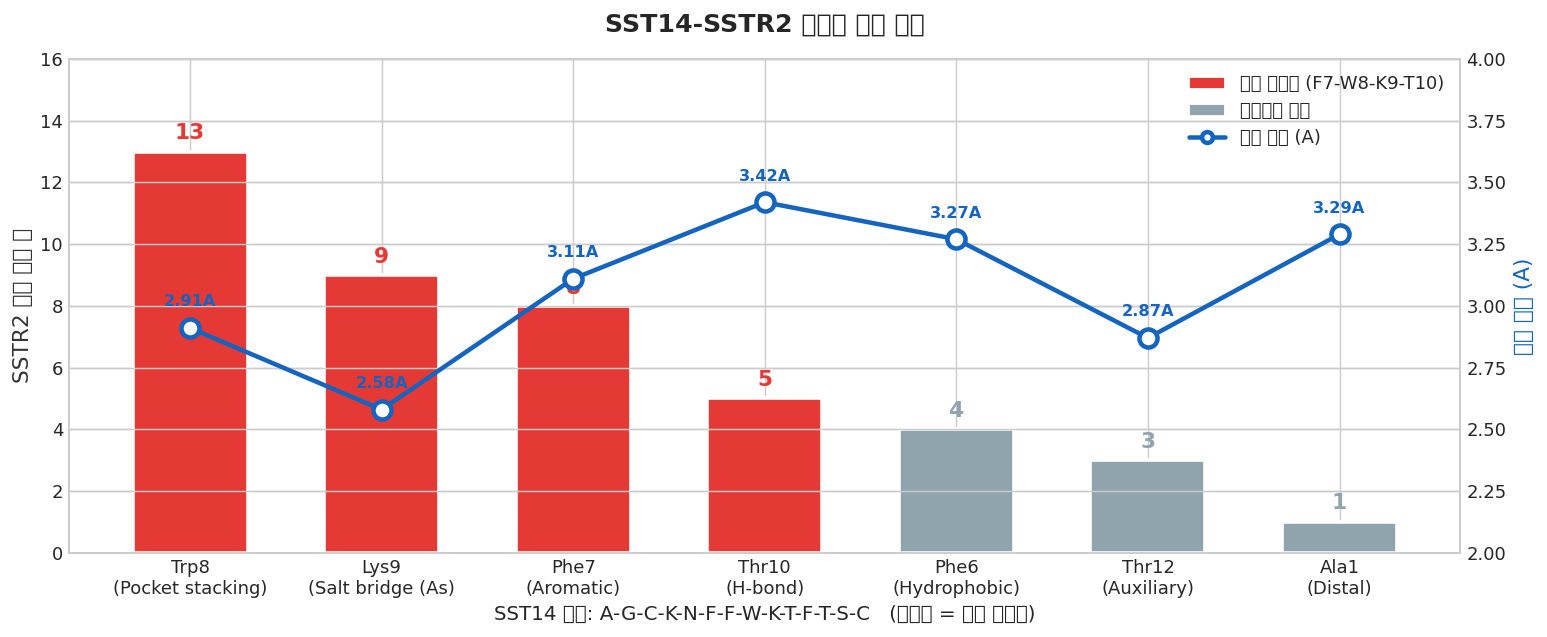

약효단 분석 저장: unified_results/pharmacophore_analysis.png


In [6]:
# ── 1.5 약효단 접촉 분석 시각화 ──
# presentation_sstr2_pipeline.ipynb의 바인딩 포켓 상세 분석 결과
pharma_data = {
    'Residue': ['Trp8', 'Lys9', 'Phe7', 'Thr10', 'Phe6', 'Thr12', 'Ala1'],
    'Contacts': [13, 9, 8, 5, 4, 3, 1],
    'Min_dist_A': [2.91, 2.58, 3.11, 3.42, 3.27, 2.87, 3.29],
    'Role': ['Pocket stacking', 'Salt bridge (Asp122)', 'Aromatic',
             'H-bond', 'Hydrophobic', 'Auxiliary', 'Distal'],
    'Is_pharmacophore': [True, True, True, True, False, False, False],
}
df_pharma = pd.DataFrame(pharma_data)

fig, ax1 = plt.subplots(figsize=(12, 5))

# 접촉 수 바차트
bar_colors = ['#e53935' if p else '#90a4ae' for p in df_pharma['Is_pharmacophore']]
bars = ax1.bar(range(len(df_pharma)), df_pharma['Contacts'],
               color=bar_colors, edgecolor='white', linewidth=2, width=0.6, zorder=3)
ax1.set_ylabel('No. of SSTR2 Contact Residues', fontsize=12, color='#333')
ax1.set_ylim(0, 16)

# 각 바 위에 접촉 수 표시
for i, (b, c) in enumerate(zip(bars, df_pharma['Contacts'])):
    ax1.text(b.get_x() + b.get_width()/2, c + 0.4, str(c),
             ha='center', fontsize=12, fontweight='bold', color=bar_colors[i])

# 최소 거리 라인 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(range(len(df_pharma)), df_pharma['Min_dist_A'],
         'o-', color='#1565c0', linewidth=2.5, markersize=10,
         markerfacecolor='white', markeredgewidth=2.5, zorder=5)
for i, d in enumerate(df_pharma['Min_dist_A']):
    ax2.annotate(f'{d:.2f}A', (i, d), textcoords="offset points",
                 xytext=(0, 12), ha='center', fontsize=9, color='#1565c0', fontweight='bold')
ax2.set_ylabel('Min Distance (Angstrom)', fontsize=12, color='#1565c0')
ax2.set_ylim(2.0, 4.0)

# x축
ax1.set_xticks(range(len(df_pharma)))
labels = []
for _, r in df_pharma.iterrows():
    lbl = f"{r['Residue']}\n({r['Role'][:15]})"
    labels.append(lbl)
ax1.set_xticklabels(labels, fontsize=10)

# 범례
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='#e53935', edgecolor='white', label='Core Pharmacophore (F7-W8-K9-T10)'),
    Patch(facecolor='#90a4ae', edgecolor='white', label='Non-pharmacophore Residues'),
    Line2D([0], [0], color='#1565c0', linewidth=2.5, marker='o',
           markerfacecolor='white', markeredgewidth=2.5, label='Min Distance (Angstrom)'),
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=10,
           framealpha=0.9, edgecolor='#ddd')

# SST14 sequences 표시
sst14_seq = 'A-G-C-K-N-F-F-W-K-T-F-T-S-C'
ax1.set_xlabel(f'SST14 Sequence: {sst14_seq}   (Red = Core Pharmacophore)', fontsize=11)
ax1.set_title('SST14-SSTR2 Pharmacophore Contact Analysis', fontweight='bold', fontsize=14, pad=15)

plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'pharmacophore_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f'Pharmacophore analysis saved: {OUTPUT_DIR / "pharmacophore_analysis.png"}')

> **입력**: `confidences`, `scores`, `pocket`, `prop_counts` (이전 셀들의 출력)
> **출력**: 3패널 시각화 (Ranking Score 바차트, pTM vs ipTM 비교, Pocket 구성 파이차트)
> **왜 실행하는가**: Phase 1 구조 QC 결과를 한눈에 파악하기 위한 시각적 요약이다.
> - **좌측**: Ranking Score — 빨간색이 최적 모델. 모든 모델이 비슷하면 구조 예측이 수렴한 것
> - **중앙**: pTM vs ipTM — ipTM이 pTM보다 낮으면 인터페이스 예측이 상대적으로 불확실
> - **우측**: Pocket 구성 — 소수성 > 극성 > 전하 순이 일반적인 GPCR 바인딩 포켓 패턴

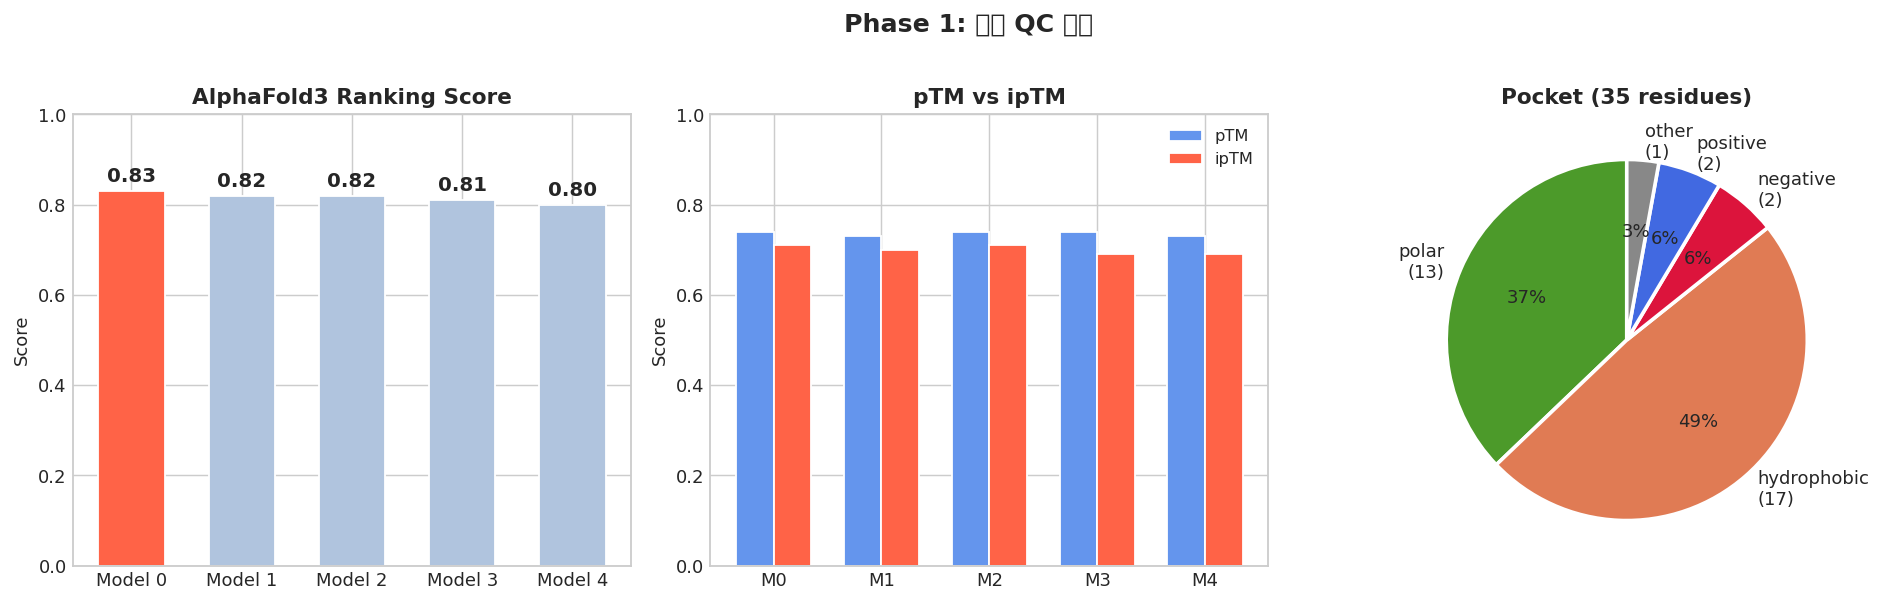

In [7]:
# ── 1.4 QC 시각화 ──
if confidences:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

    # Ranking Score
    ax = axes[0]
    colors_r = ['#FF6347' if i == best_idx else '#B0C4DE' for i in range(len(scores))]
    bars = ax.bar(range(len(scores)), scores, color=colors_r, edgecolor='white', width=0.6)
    for b, s in zip(bars, scores):
        ax.text(b.get_x() + b.get_width()/2, s + 0.02, f'{s:.2f}',
                ha='center', fontsize=11, fontweight='bold')
    ax.set_xticks(range(len(scores)))
    ax.set_xticklabels([f'Model {i}' for i in range(len(scores))])
    ax.set_ylabel('Score'); ax.set_ylim(0, 1)
    ax.set_title('AlphaFold3 Ranking Score', fontweight='bold')

    # pTM vs ipTM
    ax = axes[1]
    x = np.arange(len(confidences)); w = 0.35
    ax.bar(x - w/2, [c['ptm'] for c in confidences], w, label='pTM', color='#6495ED', edgecolor='white')
    ax.bar(x + w/2, [c['iptm'] for c in confidences], w, label='ipTM', color='#FF6347', edgecolor='white')
    ax.set_xticks(x); ax.set_xticklabels([f'M{i}' for i in range(len(confidences))])
    ax.set_ylabel('Score'); ax.set_ylim(0, 1); ax.legend(fontsize=9)
    ax.set_title('pTM vs ipTM', fontweight='bold')

    # Pocket composition
    if pocket:
        ax = axes[2]
        prop_colors = {'hydrophobic':'#E07B54','polar':'#4C9A2A','positive':'#4169E1','negative':'#DC143C','other':'#888'}
        labels_p = list(prop_counts.keys())
        sizes_p = list(prop_counts.values())
        colors_p = [prop_colors.get(l, '#888') for l in labels_p]
        ax.pie(sizes_p, labels=[f'{l}\n({s})' for l, s in zip(labels_p, sizes_p)],
               colors=colors_p, autopct='%1.0f%%', startangle=90,
               textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
        ax.set_title(f'Pocket Composition ({pocket["num_pocket_residues"]} res)', fontweight='bold')
    else:
        axes[2].axis('off')

    plt.suptitle('Phase 1: Structure QC Summary', fontweight='bold', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

### Phase 1 Summary: Structure Quality Assessment

The QC results above establish the **reliability of our starting structure**:

- **AlphaFold3 Ranking Score > 0.8**: The SSTR2-SST14 complex prediction is high-quality
- **ipTM > 0.7**: The protein-peptide interface is predicted with confidence, meaning the binding mode is trustworthy
- **FoldMason lDDT = 0.664**: Moderate structural conservation across 5 models — the binding pocket is consistent, though loop regions vary
- **Binding Pocket Composition**: Predominantly hydrophobic (Phe, Trp, Ile, Leu), supporting the aromatic pharmacophore (F7-W8-K9-T10)

These metrics collectively validate that the AlphaFold3 model is suitable as input for downstream peptide design.

> **입력**: `data/fold_test1/fold_test1_model_0.pdb` 또는 `fold_test1_model_0_from_cif.pdb`
> **출력**: SSTR2-SST14 복합체 인터랙티브 3D 뷰, HTML 파일
> **왜 실행하는가**: Phase 1 QC를 통과한 원본 구조를 3D로 확인한다. 수용체(파란색)와 펩타이드(빨간색)의 결합 모드를 시각적으로 파악할 수 있다.

In [ ]:
# ── 1.6 원본 SSTR2-SST14 복합체 3D 시각화 ──
# AlphaFold3 Best Model의 수용체-펩타이드 복합체
input_pdb_3d = DATA_DIR / 'fold_test1_model_0_from_cif.pdb'
if not input_pdb_3d.exists():
    input_pdb_3d = DATA_DIR / 'fold_test1_model_0.pdb'

if input_pdb_3d.exists():
    display(HTML(
        '<div style="background:#e3f2fd;padding:12px;border-radius:8px;margin-bottom:8px">'
        '<b>SSTR2-SST14 Original Complex</b> (AlphaFold3 Best Model)<br>'
        '<span style="color:#6495ED">&#9632;</span> SSTR2 Receptor &nbsp;|&nbsp; '
        '<span style="color:#FF6347">&#9632;</span> SST14 Peptide (AGCKNFFWKTFTSC)'
        '</div>'
    ))
    show_complex_3d(str(input_pdb_3d), title="original_complex")
else:
    print(f'PDB file not found: {input_pdb_3d}')

---
## Phase 2: FastDesign 파이프라인 (from V1)

PyRosetta 기반 물리 시뮬레이션으로 SST14 펩타이드의 서열을 최적화한다.

```
CIF → PDB → 체인 표준화 → Relax → FastDesign x20 → 필터링 → FlexPepDock Refine
```

> **LOAD_FROM_CACHE**: 이전 실행 결과가 있으면 캐시에서 로드 (시간 절약)

> **입력**: `candidates/df_candidates.csv` (기존 FastDesign 결과 캐시)
> **출력**: `LOAD_FROM_CACHE` (bool) — 캐시 로드 모드 결정
> **왜 실행하는가**: PyRosetta FastDesign 20개 후보 생성에는 **30분~1시간**이 소요된다. 이전 실행 결과가 있으면 캐시에서 로드하여 시간을 절약한다. 캐시가 없으면 자동으로 새로 실행한다.

In [8]:
# ===== FastDesign 캐시 / 실행 모드 설정 =====
# True  → 이전 실행 결과를 캐시에서 로드 (빠름)
# False → PyRosetta FastDesign 20개 새로 실행 (30분~1시간)
LOAD_FROM_CACHE = True

CACHE_DIR = Path('candidates')  # V1 result directory
CACHE_CSV = CACHE_DIR / 'df_candidates.csv'
CACHE_META = CACHE_DIR / 'meta.json'

print(f'LOAD_FROM_CACHE = {LOAD_FROM_CACHE}')
if LOAD_FROM_CACHE and CACHE_CSV.exists():
    print(f'  Cache found: {CACHE_CSV}')
elif LOAD_FROM_CACHE:
    print(f'  No cache found — switching to PyRosetta execution')
    LOAD_FROM_CACHE = False

LOAD_FROM_CACHE = True
  캐시 발견: candidates/df_candidates.csv


> **입력**: `data/fold_test1/fold_test1_model_0.cif` (AlphaFold3 CIF 구조 파일)
> **출력**: `data/fold_test1/fold_test1_model_0_from_cif.pdb` (PDB 형식 변환), `INPUT_PDB` (경로 문자열)
> **왜 실행하는가**: AlphaFold3는 mmCIF 형식으로 구조를 출력하지만, PyRosetta는 **PDB 형식만** 입력으로 지원한다. Biopython의 MMCIFParser로 파싱 후 PDBIO로 변환한다.

In [9]:
# ===== 2.1 CIF → PDB 변환 =====
if not LOAD_FROM_CACHE:
    from Bio.PDB import MMCIFParser, PDBIO

    def cif_to_pdb(cif_path, pdb_path, structure_id='AF3_MODEL'):
        parser = MMCIFParser(QUIET=True)
        structure = parser.get_structure(structure_id, str(cif_path))
        io = PDBIO()
        io.set_structure(structure)
        io.save(str(pdb_path))
        return pdb_path

    OUTPUT_PDB = DATA_DIR / 'fold_test1_model_0_from_cif.pdb'
    if not OUTPUT_PDB.exists():
        cif_to_pdb(INPUT_CIF, OUTPUT_PDB)
    INPUT_PDB = str(OUTPUT_PDB)
    print(f'INPUT_PDB: {INPUT_PDB}')
else:
    print('[Cache Mode] CIF→PDB conversion skipped')

[Cache Mode] CIF→PDB 변환 건너뜀


> **입력**: `INPUT_PDB` (PDB 구조 파일)
> **출력**: `standardized_raw.pdb` (체인 표준화), `standardized_relaxed.pdb` (에너지 최소화), `relaxed_pose` (PyRosetta Pose 객체)
> **왜 실행하는가**: PyRosetta FastDesign을 위한 3단계 전처리:
> 1. **체인 표준화** (`standardize_to_AB`): 수용체를 Chain A, 펩타이드를 Chain B로 재배치. InterfaceAnalyzerMover가 체인 A-B 인터페이스를 기준으로 동작하기 때문
> 2. **펩타이드-only Relax** (`relax_peptide_only`): 수용체는 고정하고 펩타이드만 에너지 최소화(FastRelax, ref2015 에너지 함수). AlphaFold3 구조에 남아있는 비물리적 원자 충돌을 해소하여 후속 설계의 시작점을 안정화
> 3. **Cys 잔기 보존**: 14-잔기 펩타이드에서 Cys3, Cys14은 이황화결합을 형성하므로 변이를 허용하지 않음

In [10]:
# ===== 2.2 PyRosetta 초기화 + 전처리 + FastDesign =====
if not LOAD_FROM_CACHE:
    import pyrosetta
    from pyrosetta import rosetta
    pyrosetta.init('-mute all -relax:default_repeats 3')
    print('PyRosetta initialized')

    # ── 3-letter → 1-letter 매핑 ──
    AA3_TO_1 = {
        'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C','GLN':'Q','GLU':'E',
        'GLY':'G','HIS':'H','ILE':'I','LEU':'L','LYS':'K','MET':'M','PHE':'F',
        'PRO':'P','SER':'S','THR':'T','TRP':'W','TYR':'Y','VAL':'V','MSE':'M',
    }

    # ── 펩타이드 체인 탐지 ──
    def find_peptide_chain_pose(pose, peptide_len=14):
        info = []
        for ch in range(1, pose.num_chains() + 1):
            seq = pose.chain_sequence(ch)
            info.append((ch, len(seq), seq))
        hits = [ch for ch, ln, seq in info if ln == peptide_len]
        if len(hits) != 1:
            raise RuntimeError(f'Expected exactly 1 chain with length=={peptide_len}, found: {hits}')
        return hits[0]

    # ── 체인 추출 ──
    def extract_chain_pose_by_dump(original_pose, chain_id):
        tmp_full = '__tmp_full.pdb'
        tmp_chain = f'__tmp_chain_{chain_id}.pdb'
        original_pose.dump_pdb(tmp_full)
        first_res = original_pose.chain_begin(chain_id)
        pdbinfo = original_pose.pdb_info()
        chain_letter = pdbinfo.chain(first_res) if pdbinfo else ''
        if not chain_letter.strip():
            chain_letter = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[chain_id - 1]
        with open(tmp_full, 'r') as f:
            lines = f.readlines()
        with open(tmp_chain, 'w') as out:
            for line in lines:
                if (line.startswith('ATOM') or line.startswith('HETATM')) and len(line) > 21:
                    if line[21] == chain_letter:
                        out.write(line)
                if line.startswith('TER'):
                    out.write(line)
            out.write('END\n')
        new_pose = pyrosetta.pose_from_pdb(tmp_chain)
        os.remove(tmp_full)
        os.remove(tmp_chain)
        return new_pose

    # ── 체인 표준화 ──
    def standardize_to_AB(pose, peptide_chain_id, out_pdb='standardized_raw.pdb'):
        receptor_chains = [ch for ch in range(1, pose.num_chains() + 1) if ch != peptide_chain_id]
        rec_pose = extract_chain_pose_by_dump(pose, receptor_chains[0])
        for ch in receptor_chains[1:]:
            rec_pose.append_pose_by_jump(extract_chain_pose_by_dump(pose, ch), rec_pose.total_residue())
        pep_pose = extract_chain_pose_by_dump(pose, peptide_chain_id)
        rec_pose.append_pose_by_jump(pep_pose, rec_pose.total_residue())
        rec_pose.dump_pdb(out_pdb)
        print(f'[OK] standardized -> {out_pdb} (A=receptor, B=peptide)')
        return rec_pose

    # ── Relax ──
    def relax_peptide_only(in_pdb='standardized_raw.pdb', out_pdb='standardized_relaxed.pdb',
                           peptide_chain_number=2):
        pose = pyrosetta.pose_from_pdb(in_pdb)
        sfxn = pyrosetta.create_score_function('ref2015')
        mm = rosetta.core.kinematics.MoveMap()
        mm.set_bb(False); mm.set_chi(False); mm.set_jump(False)
        for i in range(pose.chain_begin(peptide_chain_number),
                       pose.chain_end(peptide_chain_number) + 1):
            mm.set_bb(i, True); mm.set_chi(i, True)
        fr = rosetta.protocols.relax.FastRelax(sfxn, 3)
        fr.set_movemap(mm)
        fr.apply(pose)
        pose.dump_pdb(out_pdb)
        print(f'[OK] Relaxed -> {out_pdb}')
        return pose

    # ── 실행 ──
    pose = pyrosetta.pose_from_pdb(INPUT_PDB)
    pep_chain = find_peptide_chain_pose(pose, peptide_len=14)
    standard_pose = standardize_to_AB(pose, pep_chain)
    relaxed_pose = relax_peptide_only()
else:
    print('[Cache Mode] PyRosetta preprocessing skipped')

[Cache Mode] PyRosetta 전처리 건너뜀


> **입력**: 없음 (함수 정의 셀)
> **출력**: `stability_pk_proxy_scores()` 함수, `compute_rank_score()` 함수
> **왜 실행하는가**: 펩타이드 서열로부터 체내 안정성/약물동태(PK) 위험도를 **간이 추정**하는 proxy 점수를 정의한다.
>
> | Proxy 메트릭 | 수식 | 약학적 의미 |
> |-------------|------|------------|
> | `cleavage_risk` | `2.0 * (K+R) + 1.0 * (F+Y+W)` | K/R = 트립신 절단 부위, F/Y/W = 키모트립신 절단 부위. 높을수록 프로테아제 분해 위험 |
> | `pk_penalty` | `5.0 * max(0, hydro_frac - 0.5) + 0.5 * abs(net_charge)` | 과도 소수성 = 응집/낮은 용해도, 과도 전하 = 막 투과 저해 |
> | `rank_score` | `(-dG) - 0.5*cleavage - 1.0*pk_penalty` | 결합력-안정성-PK의 다목적 최적화 점수 (높을수록 좋음) |

In [11]:
# ===== 2.3 Scoring 함수 정의 =====
def stability_pk_proxy_scores(seq):
    """Calculate stability/PK proxy scores"""
    seq = seq.strip().upper()
    kr = sum(1 for x in seq if x in 'KR')
    fyw = sum(1 for x in seq if x in 'FYW')
    cleavage_risk = 2.0 * kr + 1.0 * fyw
    hydrophobic = sum(1 for x in seq if x in 'AILMFWVY')
    hydrophobic_fraction = hydrophobic / len(seq) if seq else 0
    pos_charge = sum(1 for x in seq if x in 'KRH')
    neg_charge = sum(1 for x in seq if x in 'DE')
    net_charge_proxy = pos_charge - neg_charge
    pk_penalty = 5.0 * max(0, hydrophobic_fraction - 0.5) + 0.5 * abs(net_charge_proxy)
    return {
        'cleavage_risk': cleavage_risk,
        'pk_penalty': pk_penalty,
        'hydrophobic_fraction': round(hydrophobic_fraction, 3),
        'net_charge_proxy': net_charge_proxy,
    }

def compute_rank_score(dG, cleavage_risk, pk_penalty):
    """V1 rank_score: higher = better"""
    return (-dG) - 0.5 * cleavage_risk - 1.0 * pk_penalty

print('Scoring functions defined')

Scoring 함수 정의 완료


> **입력**: `standardized_relaxed.pdb` (Relax된 복합체) 또는 `candidates/df_candidates.csv` (캐시)
> **출력**: `df_fastdesign` (DataFrame: 20개 후보의 서열, dG, dSASA, rank_score 등), `df_fd_filtered` (Cys 위반 제거 후)
> **왜 실행하는가**: Rosetta FastDesign으로 SST14 펩타이드의 **서열을 최적화**한다.
> - **설계 가능 위치**: 서열에서 Cys 자동 탐지하여 제외 (하드코딩 아님)
> - **Cys3-Cys14 보존**: 이황화결합이 환형 구조를 유지하여 약효단(F7-W8-K9-T10)을 올바른 3D 배치로 고정. 방사성의약품(DOTATATE 계열)에서도 동일한 환형 모티프가 보존됨
> - **InterfaceAnalyzerMover**: 각 후보의 dG(결합 에너지)와 dSASA(매몰 표면적)를 정량화
> - **Cys 위반 필터링**: FastDesign이 Cys를 다른 잔기로 치환한 후보를 제거하여 이황화결합 보존을 강제

In [12]:
# ===== 2.4 FastDesign 실행 또는 캐시 로드 =====
if LOAD_FROM_CACHE:
    df_fastdesign = pd.read_csv(CACHE_CSV)
    print(f'[Cache] FastDesign results loaded: {len(df_fastdesign)} candidates')
    display(df_fastdesign.head())
else:
    from pyrosetta.rosetta.protocols.analysis import InterfaceAnalyzerMover
    from pyrosetta.rosetta.core.pack.task import TaskFactory
    from pyrosetta.rosetta.core.pack.task.operation import (
        RestrictToRepacking, PreventRepacking, OperateOnResidueSubset,
    )
    from pyrosetta.rosetta.core.select.residue_selector import ChainSelector, ResidueIndexSelector
    from pyrosetta.rosetta.protocols.denovo_design.movers import FastDesign as FastDesignMover

    def analyze_interface(pose):
        iam = InterfaceAnalyzerMover(1)
        iam.set_pack_separated(True)
        iam.apply(pose)
        return {
            'dG_REU': pose.scores.get('dG_separated', pose.scores.get('dG_separated/dSASAx100', 0)),
            'dSASA': pose.scores.get('dSASA_int', 0),
        }

    def peptide_seq(pose, chain=2):
        return pose.chain_sequence(chain)

    def diff_positions(seq_wt, seq_mut):
        return [i for i, (a, b) in enumerate(zip(seq_wt, seq_mut)) if a != b]

    def build_task_factory(pose, peptide_chain_id=2, design_positions=None):
        tf = TaskFactory()
        receptor_selector = ChainSelector(1)
        tf.push_back(OperateOnResidueSubset(PreventRepacking(), receptor_selector))
        if design_positions:
            pep_start = pose.chain_begin(peptide_chain_id)
            cys_indices = []
            for i in range(pose.chain_begin(peptide_chain_id),
                           pose.chain_end(peptide_chain_id) + 1):
                if pose.residue(i).name3().strip() == 'CYS':
                    cys_indices.append(i)
            for ci in cys_indices:
                sel = ResidueIndexSelector(str(ci))
                tf.push_back(OperateOnResidueSubset(PreventRepacking(), sel))
            non_design = []
            for i in range(pose.chain_begin(peptide_chain_id),
                           pose.chain_end(peptide_chain_id) + 1):
                local_pos = i - pep_start + 1
                if local_pos not in design_positions and i not in cys_indices:
                    non_design.append(str(i))
            if non_design:
                sel = ResidueIndexSelector(','.join(non_design))
                tf.push_back(OperateOnResidueSubset(RestrictToRepacking(), sel))
        return tf

    def fastdesign_candidates(input_pdb='standardized_relaxed.pdb', n=20,
                              design_pos=None,
                              seed_base=1000, max_retries=3):
        os.makedirs('candidates', exist_ok=True)
        sfxn = pyrosetta.create_score_function('ref2015')
        design_positions = [int(x) for x in design_pos.split(',')]
        rows = []
        for i in tqdm(range(n), desc='FastDesign'):
            seed = seed_base + i
            success = False
            for attempt in range(max_retries):
                try:
                    pose = pyrosetta.pose_from_pdb(input_pdb)
                    wt_seq = peptide_seq(pose)
                    tf = build_task_factory(pose, 2, design_positions)
                    fd = FastDesignMover(sfxn)
                    fd.set_task_factory(tf)
                    pyrosetta.rosetta.numeric.random.rg().set_seed(seed + attempt * 10000)
                    fd.apply(pose)
                    mut_seq = peptide_seq(pose)
                    diffs = diff_positions(wt_seq, mut_seq)
                    out_pdb = f'candidates/candidate_{i+1:03d}.pdb'
                    pose.dump_pdb(out_pdb)
                    iface = analyze_interface(pose)
                    proxy = stability_pk_proxy_scores(mut_seq)
                    rs = compute_rank_score(iface['dG_REU'], proxy['cleavage_risk'], proxy['pk_penalty'])
                    rows.append({
                        'candidate': f'candidate_{i+1:03d}.pdb',
                        'pdb_path': out_pdb,
                        'seq': mut_seq,
                        'dG_REU': round(iface['dG_REU'], 3),
                        'dSASA': round(iface['dSASA'], 1),
                        'rank_score': round(rs, 3),
                        **proxy,
                        'mut_positions': diffs,
                    })
                    success = True
                    break
                except Exception as e:
                    if attempt == max_retries - 1:
                        print(f'  candidate {i+1} failed: {e}')
        df = pd.DataFrame(rows).sort_values('rank_score', ascending=False).reset_index(drop=True)
        df.to_csv('candidates/df_candidates.csv', index=False)
        return df

    df_fastdesign = fastdesign_candidates()
    print(f'FastDesign complete: {len(df_fastdesign)} candidates')

# ── Cys violation 필터링 ──
WT_SEQ = 'AGCKNFFWKTFTSC'
CYS_POSITIONS = [i for i, aa in enumerate(WT_SEQ) if aa == 'C']

def is_cys_violation(seq):
    for pos in CYS_POSITIONS:
        if pos < len(seq) and seq[pos] != 'C':
            return True
    return False

df_fastdesign['cys_violation'] = df_fastdesign['seq'].apply(is_cys_violation)
df_fd_filtered = df_fastdesign[~df_fastdesign['cys_violation']].copy()
print(f'Filtered: {len(df_fastdesign)} → {len(df_fd_filtered)} (Cys violation {df_fastdesign["cys_violation"].sum()} removed)')

[Cache] FastDesign 결과 로드: 20개 후보


,candidate,pdb_path,seq,dG_REU,dSASA,mut_positions,mut_outside_allowed,design_time_s,seq_distance,cleavage_risk,hydrophobic_fraction,net_charge_proxy,pk_penalty,rank_score,is_unique
0,candidate_006.pdb,candidates/candidate_006.pdb,TPCQTWFYMDAISC,-62.896705,2135.651071,"[1, 2, 4, 5, 6, 8, 9, 10, 11, 12]",[],169.927581,10,3.0,0.428571,-1,0.5,60.896705,True
1,candidate_010.pdb,candidates/candidate_010.pdb,TPCQIWFYMDAISC,-61.512458,2110.402712,"[1, 2, 4, 5, 6, 8, 9, 10, 11, 12]",[],167.834677,10,3.0,0.500000,-1,0.5,59.512458,True
2,candidate_018.pdb,candidates/candidate_018.pdb,TPCQIWYTHDAISC,-59.010072,2128.958594,"[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]",[],713.580383,11,2.0,0.357143,0,0.0,58.010072,True
3,candidate_007.pdb,candidates/candidate_007.pdb,TPCQVWFYMSAISC,-59.506794,2115.959134,"[1, 2, 4, 5, 6, 8, 9, 10, 11, 12]",[],355.182788,10,3.0,0.500000,0,0.0,58.006794,True
4,candidate_011.pdb,candidates/candidate_011.pdb,TPCQIWCTHSMISC,-58.957376,2132.929459,"[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]",[],728.263683,11,1.0,0.285714,1,0.5,57.957376,True


필터링: 20 → 20 (Cys 위반 0건 제거)


> **입력**: `df_fd_filtered` 또는 `df_fastdesign` (FastDesign 결과 DataFrame)
> **출력**: dG 및 rank_score Top 10 바차트, dG vs rank_score 상관 scatter plot
> **왜 실행하는가**: FastDesign 결과의 분포와 상관관계를 시각적으로 확인한다.
> - **dG (REU)**: Rosetta Energy Units 기반 결합 에너지. 음수이며 **절대값이 클수록 강한 결합**
> - **rank_score**: dG + 안정성/PK proxy를 결합한 다목적 최적화 점수
> - **상관 scatter**: dG가 좋아도 PK 위험이 높으면 rank_score가 낮아짐 → 약물 가능성의 균형을 확인

,candidate,seq,dG_REU,dSASA,rank_score,cleavage_risk,pk_penalty
0,candidate_006.pdb,TPCQTWFYMDAISC,-62.896705,2135.651071,60.896705,3.0,0.5
1,candidate_010.pdb,TPCQIWFYMDAISC,-61.512458,2110.402712,59.512458,3.0,0.5
2,candidate_018.pdb,TPCQIWYTHDAISC,-59.010072,2128.958594,58.010072,2.0,0.0
3,candidate_007.pdb,TPCQVWFYMSAISC,-59.506794,2115.959134,58.006794,3.0,0.0
4,candidate_011.pdb,TPCQIWCTHSMISC,-58.957376,2132.929459,57.957376,1.0,0.5
5,candidate_009.pdb,TPCQTWFYMSAISC,-58.747966,2076.703103,57.247966,3.0,0.0
6,candidate_001.pdb,TPCQFWCTHSCISC,-55.704313,2122.132177,54.204313,2.0,0.5
7,candidate_014.pdb,TPCQFWCTHSCISC,-55.670812,2123.323578,54.170812,2.0,0.5
8,candidate_004.pdb,TPCQFWCTHSCISC,-55.617462,2126.600756,54.117462,2.0,0.5
9,candidate_002.pdb,TPCQIWCTHVCISC,-55.082281,2143.757924,54.082281,1.0,0.5


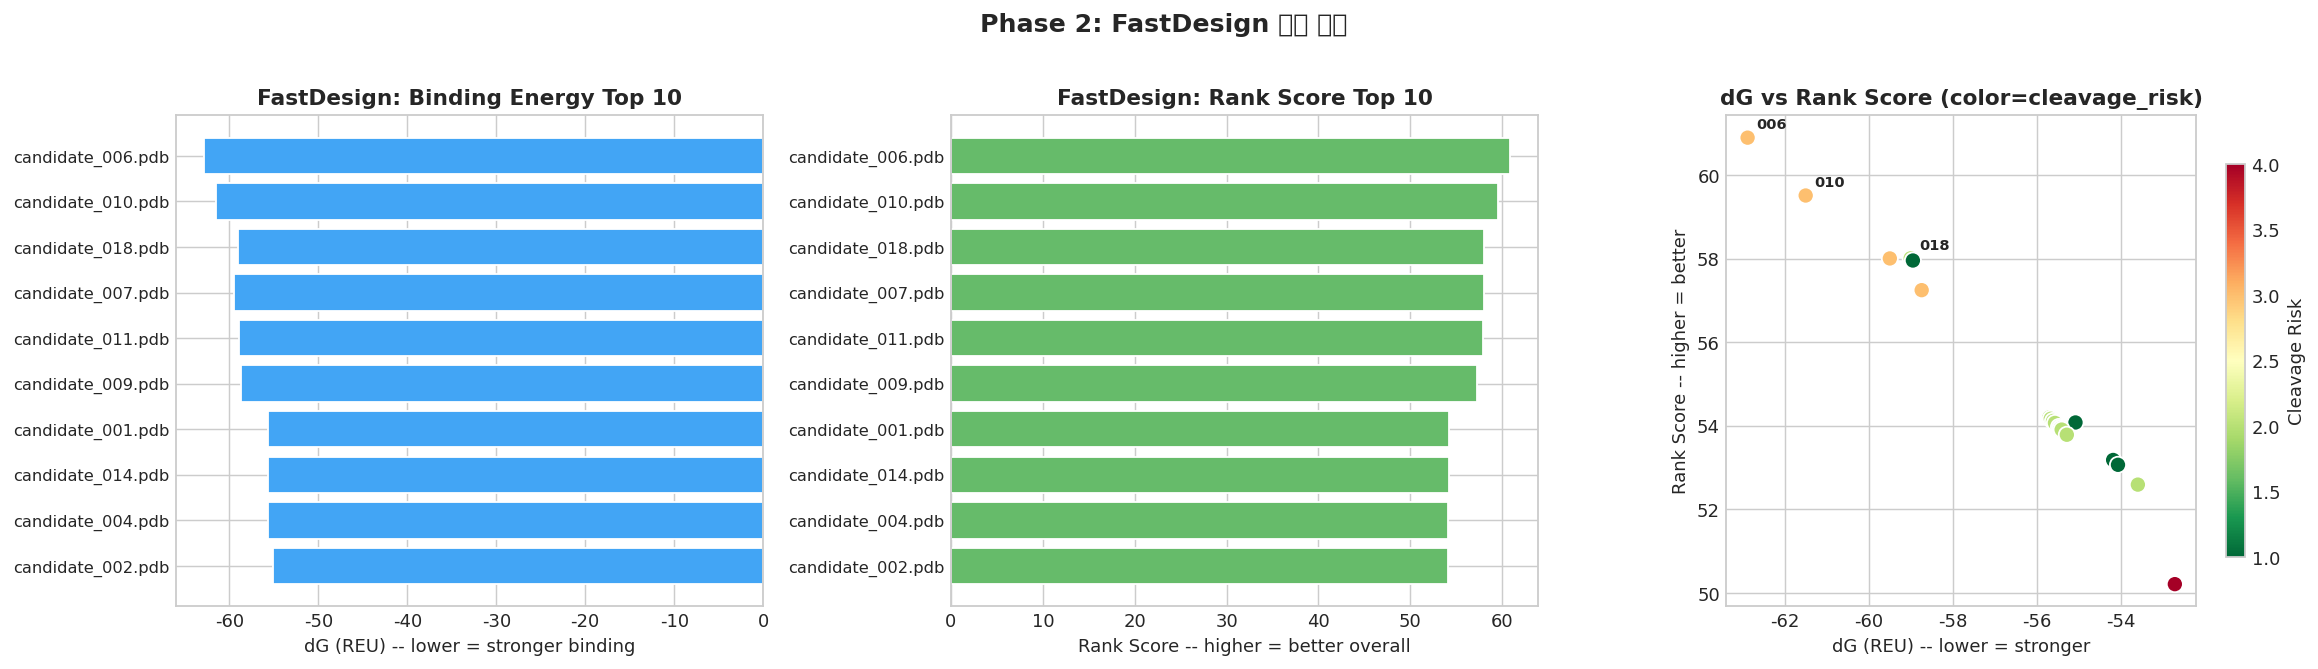

In [13]:
# ===== 2.5 FastDesign 결과 요약 =====
df_show = df_fd_filtered if len(df_fd_filtered) > 0 else df_fastdesign
cols_show = ['candidate', 'seq', 'dG_REU', 'dSASA', 'rank_score', 'cleavage_risk', 'pk_penalty']
available_cols = [c for c in cols_show if c in df_show.columns]
display(df_show[available_cols].head(10))

if 'dG_REU' in df_show.columns and 'rank_score' in df_show.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # (1) dG Top 10
    ax = axes[0]
    ax.barh(range(min(10, len(df_show))),
            df_show['dG_REU'].head(10).values,
            color='#42a5f5', edgecolor='white')
    ax.set_yticks(range(min(10, len(df_show))))
    ax.set_yticklabels(df_show['candidate'].head(10).values, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('dG (REU) — lower = stronger binding')
    ax.set_title('FastDesign: Binding Energy Top 10', fontweight='bold')

    # (2) Rank Score Top 10
    ax = axes[1]
    ax.barh(range(min(10, len(df_show))),
            df_show['rank_score'].head(10).values,
            color='#66bb6a', edgecolor='white')
    ax.set_yticks(range(min(10, len(df_show))))
    ax.set_yticklabels(df_show['candidate'].head(10).values, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Rank Score — higher = better overall')
    ax.set_title('FastDesign: Rank Score Top 10', fontweight='bold')

    # (3) dG vs rank_score scatter (Task 7)
    ax = axes[2]
    sc = ax.scatter(df_show['dG_REU'], df_show['rank_score'],
                    c=df_show['cleavage_risk'], cmap='RdYlGn_r',
                    s=80, edgecolor='white', linewidth=1, zorder=5)
    ax.set_xlabel('dG (REU) — lower = stronger')
    ax.set_ylabel('Rank Score — higher = better')
    ax.set_title('dG vs Rank Score (color=cleavage_risk)', fontweight='bold')
    plt.colorbar(sc, ax=ax, label='Cleavage Risk', shrink=0.8)
    # Top 3 annotate
    for i in range(min(3, len(df_show))):
        r = df_show.iloc[i]
        ax.annotate(r['candidate'].replace('candidate_','').replace('.pdb',''),
                    (r['dG_REU'], r['rank_score']),
                    textcoords='offset points', xytext=(5, 5), fontsize=8, fontweight='bold')

    plt.suptitle('Phase 2: FastDesign Results Analysis', fontweight='bold', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

> **입력**: `candidates/candidate_*.pdb` (FastDesign 결과 PDB 파일)
> **출력**: Top 3 후보의 3D 비교 뷰, HTML 파일
> **왜 실행하는가**: FastDesign Top 3 후보가 수용체 포켓에 어떻게 결합하는지 3D로 비교한다. 서열 변이에 따른 결합 모드 차이를 시각적으로 확인할 수 있다.

In [ ]:
# ── 2.6 FastDesign Top 3 후보 3D 시각화 ──
if HAS_3D and len(df_show) >= 3:
    top3_fd = df_show.head(3)
    pdb_paths_fd = []
    labels_fd = []
    for _, row in top3_fd.iterrows():
        pdb_p = Path('candidates') / row['candidate']
        if pdb_p.exists():
            pdb_paths_fd.append(str(pdb_p))
            dg = row.get('dG_REU', 0)
            labels_fd.append(f"{row['candidate'].replace('.pdb','')} (dG={dg:.1f})")

    if pdb_paths_fd:
        display(HTML(
            '<div style="background:#e8f5e9;padding:12px;border-radius:8px;margin-bottom:8px">'
            '<b>FastDesign Top 3 Candidates Comparison</b><br>'
            '<span style="color:#6495ED">&#9632;</span> SSTR2 Receptor &nbsp;|&nbsp; '
            '<span style="color:#FF6347">&#9632;</span> '
            '<span style="color:#FF69B4">&#9632;</span> '
            '<span style="color:#32CD32">&#9632;</span> Peptide Candidates'
            '</div>'
        ))
        show_comparison_3d(pdb_paths_fd, labels_fd)
    else:
        print('FastDesign PDB files not found — skipping 3D comparison')
elif not HAS_3D:
    print('py3Dmol not installed — skipping 3D visualization')
else:
    print(f'Insufficient candidates ({len(df_show)}) — skipping 3D comparison')

### Phase 2 Summary: FastDesign Peptide Optimization

FastDesign generated **20 candidate sequences** by mutating the SST14 peptide within the SSTR2 binding pocket using Rosetta's ref2015 energy function.

Key observations:
- **Cys3 and Cys14 are preserved** in all valid candidates, maintaining the cyclic disulfide bond essential for pharmacophore geometry
- **dG (binding energy)** directly quantifies binding affinity — candidates with more negative dG bind more strongly
- **Rank Score** balances binding affinity against protease cleavage risk and PK penalty, identifying candidates that are both potent and drug-like
- Many candidates converge to similar sequences due to the constrained energy landscape of the cyclic peptide in the deep GPCR pocket

---
## Phase 3: De Novo 파이프라인 (Arm 3)

RFdiffusion + ProteinMPNN + ESMFold로 SSTR2에 결합하는 **완전히 새로운** 펩타이드를 설계한다.

| 단계 | 도구 | 역할 |
|------|------|------|
| Step 1 | RFdiffusion | 바인딩 포켓에 맞는 백본 생성 |
| Step 2 | ProteinMPNN | 백본 → 최적 서열 |
| Step 3 | ESMFold | 서열 → 구조 예측 (pLDDT 검증) |

> **RUN_DENOVO**: False이면 기존 결과 로드, True이면 NIM API 호출

> **입력**: `DENOVO_DIR / 'arm3_final_*.json'` (캐시 파일), `HAS_API` (API 가용 여부)
> **출력**: `RUN_DENOVO` (bool) — De Novo 파이프라인 실행 모드 결정
> **왜 실행하는가**: NVIDIA BioNeMo NIM API를 사용하는 De Novo 파이프라인은 **클라우드 API 호출**이 필요하다. API 키가 없거나 기존 결과가 있으면 캐시 모드로 전환한다.

In [14]:
# ===== De Novo 실행/로드 모드 =====
RUN_DENOVO = False  # True → NIM API call, False → load cached results

DENOVO_RESULT_FILE = DENOVO_DIR / 'arm3_final_20260210_000106.json'

if not RUN_DENOVO and DENOVO_RESULT_FILE.exists():
    print(f'[Load] Existing De Novo results: {DENOVO_RESULT_FILE}')
elif not HAS_API:
    print('No API key + no cached results → skipping De Novo')
    RUN_DENOVO = False
else:
    print('[Run] Running De Novo pipeline via NIM API')

[Load] 기존 De Novo 결과: /mnt/g/repos/bio/results/sstr2_docking/arm3_denovo/arm3_final_20260210_000106.json


> **입력**: `binding_pocket.json` (포켓 정보, hotspot 잔기), `sstr2_receptor.pdb` (수용체 구조), 또는 캐시 JSON
> **출력**: `df_denovo` (DataFrame: backbone_idx, binder_sequence, pLDDT, cleavage_risk, pk_penalty)
> **왜 실행하는가**: SST14 서열과 **무관하게** 완전히 새로운 결합 펩타이드를 생성한다.
> 1. **RFdiffusion**: 바인딩 포켓의 hotspot 잔기에 대해 10~30잔기 펩타이드 백본을 **확산 모델**로 생성 (새로운 결합 모드 탐색)
> 2. **ProteinMPNN**: 생성된 백본의 3D 구조에 맞는 **최적 아미노산 서열**을 역 폴딩(inverse folding)으로 설계
> 3. **ESMFold**: 설계된 서열이 의도한 3D 구조로 접히는지 **pLDDT 점수**로 검증 (70+ = 고신뢰)
>
> 이 파이프라인의 강점: 기존 SST14 scaffold에 제한되지 않아, 기존에 발견되지 않은 결합 모드까지 탐색할 수 있음

In [15]:
# ===== 3.1 De Novo 실행 또는 결과 로드 =====
df_denovo = None

if RUN_DENOVO and HAS_API:
    # ── NIM API로 Arm 3 실행 ──
    from rfdiffusion_client import get_client as get_rfdiffusion
    from proteinmpnn_client import get_client as get_proteinmpnn
    from esmfold_client import get_client as get_esmfold

    pocket_info = json.loads((DOCKING_DIR / 'binding_pocket.json').read_text())
    hotspot_res = pocket_info.get('hotspot_res', [])
    rfdiff_contigs = pocket_info.get('rfdiffusion', {}).get('contigs', 'B1-369/0 10-30')
    receptor_pdb = DOCKING_DIR / 'sstr2_receptor.pdb'

    NUM_DESIGNS = 5
    SEQS_PER_BB = 4

    rfdiff = get_rfdiffusion()
    mpnn = get_proteinmpnn()
    esmfold = get_esmfold()

    designs = []
    print('[Step 1] RFdiffusion backbone design')
    backbones = []
    for i in tqdm(range(NUM_DESIGNS), desc='RFdiffusion'):
        try:
            result = rfdiff.design_binder(
                pdb_path=receptor_pdb, contigs=rfdiff_contigs,
                hotspot_res=hotspot_res[:10], diffusion_steps=50, random_seed=i)
            if result.get('output_pdb'):
                backbones.append({'idx': i, 'pdb': result['output_pdb']})
        except Exception as e:
            print(f'  backbone {i} error: {e}')

    print(f'[Step 2] ProteinMPNN sequence design ({len(backbones)} backbones)')
    seq_designs = []
    for bb in backbones:
        try:
            result = mpnn.predict(input_pdb=bb['pdb'], num_seq_per_target=SEQS_PER_BB, sampling_temp=0.2)
            seqs = result.get('sequences', [])
            if isinstance(seqs, str):
                entries = mpnn.parse_fasta(seqs)
                seqs = [e['sequence'] for e in entries]
            for j, seq in enumerate(seqs):
                seq_designs.append({'backbone_idx': bb['idx'], 'seq_idx': j, 'binder_sequence': seq})
        except Exception as e:
            print(f'  MPNN error: {e}')

    print(f'[Step 3] ESMFold folding validation ({len(seq_designs)} sequences)')
    for sd in tqdm(seq_designs, desc='ESMFold'):
        try:
            result = esmfold.predict(sd['binder_sequence'])
            sd['plddt'] = result.get('mean_plddt', result.get('plddt', None))
        except Exception as e:
            sd['plddt'] = None

    df_denovo = pd.DataFrame(seq_designs)
    if 'plddt' in df_denovo.columns:
        df_denovo = df_denovo.dropna(subset=['plddt'])
        df_denovo = df_denovo.sort_values('plddt', ascending=False).reset_index(drop=True)
    print(f'De Novo complete: {len(df_denovo)} designs')

elif DENOVO_RESULT_FILE.exists():
    # ── 기존 결과 로드 ──
    arm3_data = json.loads(DENOVO_RESULT_FILE.read_text())
    df_denovo = pd.DataFrame(arm3_data['designs'])
    # stability proxy 추가
    for idx, row in df_denovo.iterrows():
        proxy = stability_pk_proxy_scores(row['binder_sequence'])
        for k, v in proxy.items():
            df_denovo.at[idx, k] = v
    df_denovo = df_denovo.sort_values('plddt', ascending=False).reset_index(drop=True)
    print(f'[Load] De Novo results: {len(df_denovo)} designs')

if df_denovo is not None:
    display(df_denovo[['backbone_idx', 'binder_sequence', 'plddt',
                       'cleavage_risk', 'pk_penalty']].head(10))

[Load] De Novo 결과: 16개 설계


,backbone_idx,binder_sequence,plddt,cleavage_risk,pk_penalty
0,3,AALARTIAARFRKELEA,81.388712,9.0,1.441176
1,3,AALARTIRADFRAQQQA,81.153485,7.0,1.147059
2,0,SGLTGGLLALRRYAELARRYLE,80.356092,10.0,1.000000
3,1,AAALGLLLFEAAEQ,79.886061,1.0,2.071429
4,0,AGLTGGLAAYREYCRLARRLLE,76.936725,10.0,1.000000
5,3,AALWQTILTRFRRQQEE,74.664437,8.0,0.500000
6,1,MAALGLLLFEYAEQ,73.586789,2.0,2.071429
7,0,TPLTGGEAQLVRYASLARRYLE,73.311156,8.0,0.500000
8,0,MPITGGLVSLRRKAELSRRYLE,71.061525,11.0,1.500000
9,2,PALIWAEGRGE,69.271905,3.0,0.500000


> **입력**: `df_denovo` (De Novo 파이프라인 결과 DataFrame)
> **출력**: `unified_results/denovo_candidates.csv`, `unified_results/denovo_candidates.fasta`
> **왜 실행하는가**: De Novo 후보의 서열, pLDDT, PK proxy 점수를 CSV/FASTA로 저장하여 후속 분석(FlexPepDock, 실험 검증 등)에서 재사용할 수 있도록 한다.

In [ ]:
# ===== 3.1b De Novo 결과 저장 =====
if df_denovo is not None and len(df_denovo) > 0:
    # CSV 저장
    denovo_csv = OUTPUT_DIR / 'denovo_candidates.csv'
    df_denovo.to_csv(denovo_csv, index=False)
    print(f'[Save] De Novo candidates CSV: {denovo_csv} ({len(df_denovo)} candidates)')

    # FASTA 저장
    denovo_fasta = OUTPUT_DIR / 'denovo_candidates.fasta'
    with open(denovo_fasta, 'w') as f:
        for _, row in df_denovo.iterrows():
            name = f"bb{row['backbone_idx']:02d}_seq{row['seq_idx']}"
            plddt = row.get('plddt', 0) or 0
            f.write(f'>{name} pLDDT={plddt:.1f}\n')
            f.write(f"{row['binder_sequence']}\n")
    print(f'[Save] De Novo candidates FASTA: {denovo_fasta}')

    # ESMFold PDB 파일 경로 매핑
    if 'esmfold_pdb' in df_denovo.columns:
        pdb_count = 0
        for _, row in df_denovo.iterrows():
            pdb_rel = row.get('esmfold_pdb', '')
            if pdb_rel:
                pdb_abs = (Path('.').resolve().parent / pdb_rel.lstrip('../')).resolve()
                if not pdb_abs.exists():
                    pdb_abs = DENOVO_DIR / Path(pdb_rel).name
                if pdb_abs.exists():
                    pdb_count += 1
        print(f'[Info] ESMFold PDB files: {pdb_count}/{len(df_denovo)} found')
    display(df_denovo[['backbone_idx', 'binder_sequence', 'plddt',
                       'cleavage_risk', 'pk_penalty']].describe().round(2))
else:
    print('[Skip] No De Novo results — skipping save')

> **입력**: `df_denovo` (De Novo 결과 DataFrame)
> **출력**: pLDDT rank plot, 서열 길이 분포 히스토그램
> **왜 실행하는가**: De Novo 설계 결과의 품질 분포를 확인한다.
> - **pLDDT 70 이상**: ESMFold이 높은 신뢰도로 구조를 예측 = 설계 서열이 안정적으로 폴딩됨
> - **pLDDT 50 미만**: 폴딩이 불안정하거나 무질서(disordered)할 가능성 → 후보에서 제외 권장
> - **서열 길이**: RFdiffusion이 10~30 잔기 범위에서 백본을 생성. SST14(14 잔기)보다 긴/짧은 후보가 나올 수 있음

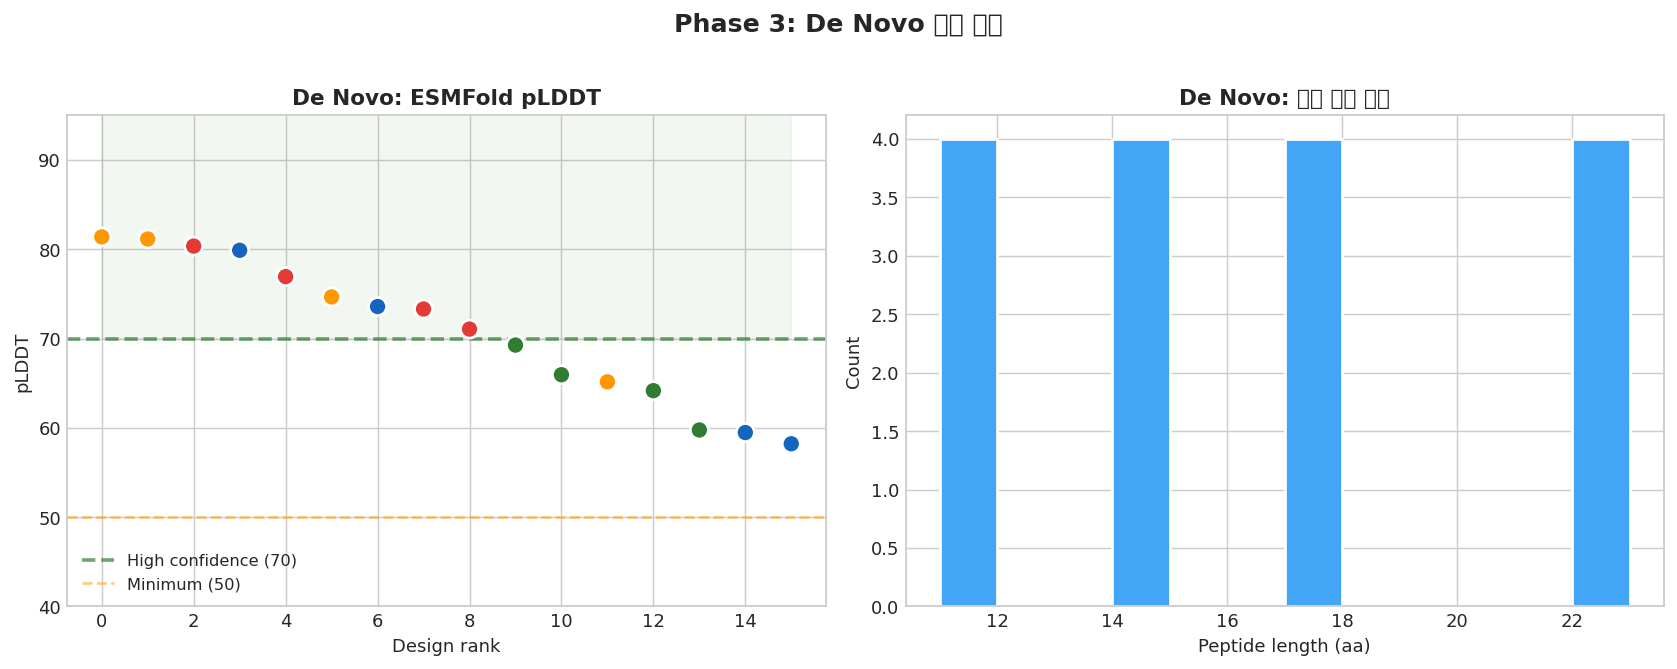

In [16]:
# ===== 3.2 De Novo 시각화 =====
if df_denovo is not None and len(df_denovo) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # pLDDT 분포
    plddts = df_denovo['plddt'].values
    bb_ids = df_denovo['backbone_idx'].values
    bb_colors = {0: '#e53935', 1: '#1565c0', 2: '#2e7d32', 3: '#ff9800', 4: '#9c27b0'}
    colors = [bb_colors.get(b, '#888') for b in bb_ids]

    ax1.scatter(range(len(plddts)), np.sort(plddts)[::-1],
                c=[bb_colors.get(bb_ids[i], '#888') for i in np.argsort(plddts)[::-1]],
                s=100, edgecolor='white', linewidth=1.5, zorder=5)
    ax1.axhline(y=70, color='#2e7d32', linestyle='--', linewidth=2, alpha=0.7, label='High confidence (70)')
    ax1.axhline(y=50, color='#ff9800', linestyle='--', linewidth=1.5, alpha=0.5, label='Minimum (50)')
    ax1.fill_between(range(len(plddts)), 70, 100, alpha=0.06, color='#2e7d32')
    ax1.set_xlabel('Design rank'); ax1.set_ylabel('pLDDT')
    ax1.set_title('De Novo: ESMFold pLDDT', fontweight='bold')
    ax1.set_ylim(40, 95); ax1.legend(fontsize=9)

    # sequences 길이 분포
    lengths = df_denovo['binder_sequence'].str.len()
    ax2.hist(lengths, bins=range(int(lengths.min()), int(lengths.max()) + 2),
             color='#42a5f5', edgecolor='white', linewidth=1.5)
    ax2.set_xlabel('Peptide length (aa)')
    ax2.set_ylabel('Count')
    ax2.set_title('De Novo: Peptide Length Distribution', fontweight='bold')

    plt.suptitle('Phase 3: De Novo Design Results', fontweight='bold', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

> **입력**: `df_denovo` (De Novo 결과), ESMFold PDB 파일 (`results/sstr2_docking/arm3_denovo/esmfold_*.pdb`)
> **출력**: Top 3 De Novo 후보의 pLDDT 색상 3D 뷰, HTML 파일
> **왜 실행하는가**: De Novo 설계 서열의 **폴딩 품질**을 3D로 확인한다. 빨간색=고신뢰(pLDDT 높음), 파란색=저신뢰. 잘 접히는 영역과 유연한 영역을 구분할 수 있다.

In [ ]:
# ── 3.3 De Novo Top 3 3D 시각화 (pLDDT 색상) ──
if HAS_3D and df_denovo is not None and len(df_denovo) > 0:
    # ESMFold PDB 경로 확인
    denovo_pdbs = []
    denovo_labels = []
    for _, row in df_denovo.head(5).iterrows():
        pdb_rel = row.get('esmfold_pdb', '')
        pdb_path = None
        if pdb_rel:
            # 상대 경로 해석
            candidate = REPO / pdb_rel.lstrip('../')
            if candidate.exists():
                pdb_path = candidate
            else:
                candidate2 = DENOVO_DIR / Path(pdb_rel).name
                if candidate2.exists():
                    pdb_path = candidate2
        if pdb_path is None:
            # 파일명 패턴으로 탐색
            pattern_name = f"esmfold_bb{int(row['backbone_idx']):02d}_seq{int(row['seq_idx'])}.pdb"
            candidate3 = DENOVO_DIR / pattern_name
            if candidate3.exists():
                pdb_path = candidate3

        if pdb_path and pdb_path.exists():
            plddt = row.get('plddt', 0) or 0
            denovo_pdbs.append(str(pdb_path))
            denovo_labels.append(f"bb{int(row['backbone_idx']):02d}_s{int(row['seq_idx'])} pLDDT={plddt:.0f}")
        if len(denovo_pdbs) >= 3:
            break

    if denovo_pdbs:
        display(HTML(
            '<div style="background:#fce4ec;padding:12px;border-radius:8px;margin-bottom:8px">'
            '<b>De Novo Top 3: ESMFold Structure (pLDDT Coloring)</b><br>'
            '<span style="color:red">&#9632;</span> High confidence (pLDDT > 70) &nbsp;|&nbsp; '
            '<span style="color:white;text-shadow:0 0 2px #000">&#9632;</span> Medium &nbsp;|&nbsp; '
            '<span style="color:blue">&#9632;</span> Low confidence (pLDDT < 50)'
            '</div>'
        ))
        for pdb_p, label in zip(denovo_pdbs, denovo_labels):
            print(f'  {label}')
            show_peptide_plddt_3d(pdb_p, title=f"denovo_{label.split()[0]}")
    else:
        print('De Novo ESMFold PDB files not found — skipping 3D visualization')
elif not HAS_3D:
    print('py3Dmol not installed — skipping 3D visualization')
else:
    print('No De Novo results — skipping 3D visualization')

### Phase 3 Summary: De Novo Peptide Generation

The De Novo pipeline explored **entirely new binding modes** using AI generative models:

- **RFdiffusion** generated novel peptide backbones complementary to the SSTR2 binding pocket, unconstrained by the SST14 scaffold
- **ProteinMPNN** designed optimal amino acid sequences for each backbone through inverse folding
- **ESMFold** validated that designed sequences fold into the intended 3D structures (pLDDT > 70 = high confidence)

Unlike FastDesign candidates (which are SST14 variants), De Novo candidates may adopt **completely different binding orientations and contact residue patterns**, potentially discovering peptides that outperform natural somatostatin analogs.

---
## Phase 3.5: De Novo 후보 FlexPepDock 정제

De Novo 파이프라인에서 생성된 후보는 pLDDT(폴딩 신뢰도)만 있고, SSTR2와의 **결합 에너지(dG)**가 없다.
FastDesign 후보와 **동일한 에너지 함수 기반**으로 비교하려면, De Novo 후보도 FlexPepDock으로 정제하여
dG/dSASA를 측정해야 한다.

### 파이프라인

```
De Novo 서열 → 수용체-펩타이드 복합체 구성 → FlexPepDock 정제 → InterfaceAnalyzer (dG/dSASA)
```

### 과학적 근거

| 문제 | 해결 |
|------|------|
| pLDDT는 폴딩 신뢰도이지 결합 친화도가 아님 | FlexPepDock으로 dG를 직접 계산 |
| FastDesign(dG) vs De Novo(pLDDT) 비교 불가 | 동일한 Rosetta 에너지 함수로 통일 |
| De Novo 백본이 수용체 포켓에 최적화되지 않음 | FlexPepDock이 백본/측쇄 모두 정밀화 |

> **LOAD_DENOVO_REFINE**: 이전 실행 결과가 있으면 캐시에서 로드

In [17]:
# ===== Phase 3.5: De Novo FlexPepDock 정제 =====
LOAD_DENOVO_REFINE = True  # True → load cache, False → run PyRosetta
DENOVO_REFINE_CSV = OUTPUT_DIR / 'denovo_refined.csv'
TOPK_DENOVO_REFINE = 10  # Refine top N De Novo candidates

df_denovo_refined = None

if df_denovo is not None and len(df_denovo) > 0:
    if LOAD_DENOVO_REFINE and DENOVO_REFINE_CSV.exists():
        df_denovo_refined = pd.read_csv(DENOVO_REFINE_CSV)
        print(f'[Cache] De Novo refinement results loaded: {len(df_denovo_refined)} candidates')
        display(df_denovo_refined.head())
    elif not LOAD_DENOVO_REFINE:
        import pyrosetta
        from pyrosetta.rosetta.protocols.flexpep_docking import FlexPepDockingProtocol
        from pyrosetta.rosetta.protocols.analysis import InterfaceAnalyzerMover

        if not pyrosetta.rosetta.basic.was_init_called():
            pyrosetta.init('-mute all -relax:default_repeats 3')

        receptor_pdb_path = str(DOCKING_DIR / 'sstr2_receptor.pdb')
        sfxn = pyrosetta.create_score_function('ref2015')

        def make_complex_pose(receptor_pdb, peptide_seq):
            """Build receptor-peptide complex Pose from receptor PDB and peptide sequence"""
            rec_pose = pyrosetta.pose_from_pdb(receptor_pdb)
            # 펩타이드를 확장 구조로 생성 후 수용체에 부착
            pep_pose = pyrosetta.pose_from_sequence(peptide_seq)
            rec_pose.append_pose_by_jump(pep_pose, rec_pose.total_residue())
            return rec_pose

        def flexpepdock_refine_denovo(df_in, topk=TOPK_DENOVO_REFINE):
            os.makedirs(str(OUTPUT_DIR / 'denovo_refined'), exist_ok=True)
            rows = []
            top_df = df_in.head(topk)

            for idx, (_, row) in enumerate(tqdm(top_df.iterrows(),
                                                 total=len(top_df),
                                                 desc='FlexPepDock (De Novo)')):
                try:
                    pep_seq = row['binder_sequence']
                    pose = make_complex_pose(receptor_pdb_path, pep_seq)

                    fpd = FlexPepDockingProtocol()
                    fpd.apply(pose)

                    # Interface analysis
                    iam = InterfaceAnalyzerMover(1)
                    iam.set_pack_separated(True)
                    iam.apply(pose)
                    dG = pose.scores.get('dG_separated',
                                          pose.scores.get('dG_separated/dSASAx100', 0))
                    dSASA = pose.scores.get('dSASA_int', 0)

                    proxy = stability_pk_proxy_scores(pep_seq)
                    out_name = f"denovo_refined_{idx+1:03d}.pdb"
                    out_path = str(OUTPUT_DIR / 'denovo_refined' / out_name)
                    pose.dump_pdb(out_path)

                    rows.append({
                        'source_name': f"bb{row['backbone_idx']:02d}_seq{row['seq_idx']}",
                        'binder_sequence': pep_seq,
                        'plddt': row.get('plddt', 0),
                        'dG_REU': round(dG, 3),
                        'dSASA': round(dSASA, 1),
                        'pdb_path': out_path,
                        **proxy,
                    })
                except Exception as e:
                    print(f'  De Novo refine {idx+1} failed: {e}')

            df = pd.DataFrame(rows)
            if len(df) > 0:
                df['rank_score'] = (-df['dG_REU']) - 0.5 * df['cleavage_risk'] - 1.0 * df['pk_penalty']
                df = df.sort_values('rank_score', ascending=False).reset_index(drop=True)
                df.to_csv(DENOVO_REFINE_CSV, index=False)
                print(f'De Novo refinement complete: {len(df)} candidates, saved: {DENOVO_REFINE_CSV}')
            return df

        df_denovo_refined = flexpepdock_refine_denovo(df_denovo)
        if len(df_denovo_refined) > 0:
            display(df_denovo_refined.head())
    else:
        print('[Skip] De Novo FlexPepDock refinement: no cache + LOAD_DENOVO_REFINE=True → skipping')
        print('  → Set LOAD_DENOVO_REFINE = False and re-run, or prepare cache file')
else:
    print('[Skip] No De Novo results — skipping FlexPepDock refinement')

[Skip] De Novo FlexPepDock 정제: 캐시 없음 + LOAD_DENOVO_REFINE=True → 건너뜀
  → LOAD_DENOVO_REFINE = False로 변경 후 재실행하거나, 캐시 파일을 준비하세요


---
## Phase 4: 통합 랭킹 — Weighted Score

두 파이프라인의 후보를 하나의 DataFrame으로 병합하고, 정규화된 가중합 점수로 랭킹한다.

### FlexPepDock 정제를 통한 공정한 비교

Phase 3.5에서 De Novo 후보도 FlexPepDock으로 정제하여 **dG(결합 에너지)를 측정**했다.
이로써 FastDesign과 De Novo 모든 후보가 **동일한 Rosetta 에너지 함수(ref2015) 기반**의
결합 에너지로 비교된다.

### 통합 점수 공식

```
unified_score = w_binding   x norm(-dG)         # 결합력: 모든 후보 dG 기반
              + w_structure x norm(structure)     # 구조 신뢰도: dSASA 또는 pLDDT
              - w_risk      x norm(risk_total)    # PK 위험 페널티
```

| 가중치 | 기본값 | 의미 |
|--------|--------|------|
| `w_binding` | 0.50 | 결합력 — 모든 후보에 대해 dG (Rosetta) 기반 |
| `w_structure` | 0.30 | 구조 신뢰도 — FastDesign: dSASA, De Novo: pLDDT |
| `w_risk` | 0.20 | 안정성/PK 위험 페널티 (cleavage_risk + pk_penalty) |

> **입력**: `df_fd_filtered` (FastDesign 후보), `df_denovo_refined` (FlexPepDock 정제된 De Novo 후보)
> **출력**: `df_unified` (통합 DataFrame), `unified_ranking.csv` 파일
> **왜 실행하는가**: 두 파이프라인의 후보를 하나의 DataFrame으로 병합한다. FlexPepDock 정제를 통해 모든 후보가 dG를 가지므로 `binding_metric = -dG` 로 통일하여 과학적으로 공정한 비교가 가능하다.

In [18]:
# ===== 4.1 통합 DataFrame 구성 =====
W_BINDING   = 0.50
W_STRUCTURE = 0.30
W_RISK      = 0.20

rows_unified = []

# ── FastDesign 후보 추가 ──
df_fd_src = df_fd_filtered if len(df_fd_filtered) > 0 else df_fastdesign
for _, row in df_fd_src.iterrows():
    dG = row.get('dG_REU', 0)
    rows_unified.append({
        'source': 'FastDesign',
        'name': row.get('candidate', ''),
        'sequence': row.get('seq', ''),
        'length': len(row.get('seq', '')),
        'binding_metric': -dG,  # higher = better (sign flipped)
        'structure_metric': row.get('dSASA', 0),  # dSASA: larger = broader contact
        'plddt': None,  # FastDesign has no pLDDT
        'dG_REU': dG,
        'dSASA': row.get('dSASA', 0),
        'cleavage_risk': row.get('cleavage_risk', 0),
        'pk_penalty': row.get('pk_penalty', 0),
        'risk_total': row.get('cleavage_risk', 0) + row.get('pk_penalty', 0),
        'rank_score_v1': row.get('rank_score', 0),
    })

# ── De Novo 후보 추가 (FlexPepDock 정제된 결과 우선) ──
if df_denovo_refined is not None and len(df_denovo_refined) > 0:
    # FlexPepDock 정제 결과 사용 → dG 기반 공정 비교 가능
    for _, row in df_denovo_refined.iterrows():
        dG = row.get('dG_REU', 0)
        plddt = row.get('plddt', 0) or 0
        rows_unified.append({
            'source': 'DeNovo',
            'name': row.get('source_name', ''),
            'sequence': row.get('binder_sequence', ''),
            'length': len(row.get('binder_sequence', '')),
            'binding_metric': -dG,  # dG from FlexPepDock (same energy function)
            'structure_metric': plddt,  # ESMFold pLDDT (structural confidence)
            'plddt': plddt,
            'dG_REU': dG,
            'dSASA': row.get('dSASA', None),
            'cleavage_risk': row.get('cleavage_risk', 0),
            'pk_penalty': row.get('pk_penalty', 0),
            'risk_total': row.get('cleavage_risk', 0) + row.get('pk_penalty', 0),
            'rank_score_v1': row.get('rank_score', None),
        })
elif df_denovo is not None:
    # FlexPepDock 미실행 → pLDDT fallback (한계 경고 포함)
    print('De Novo FlexPepDock refinement not completed — using pLDDT as binding proxy (Warning: not directly comparable to dG)')
    for _, row in df_denovo.iterrows():
        plddt = row.get('plddt', 0) or 0
        rows_unified.append({
            'source': 'DeNovo',
            'name': f"bb{row['backbone_idx']:02d}_seq{row['seq_idx']}",
            'sequence': row.get('binder_sequence', ''),
            'length': len(row.get('binder_sequence', '')),
            'binding_metric': plddt,  # fallback: pLDDT
            'structure_metric': plddt,
            'plddt': plddt,
            'dG_REU': None,
            'dSASA': None,
            'cleavage_risk': row.get('cleavage_risk', 0),
            'pk_penalty': row.get('pk_penalty', 0),
            'risk_total': row.get('cleavage_risk', 0) + row.get('pk_penalty', 0),
            'rank_score_v1': None,
        })

df_unified = pd.DataFrame(rows_unified)
print(f'Unified candidates: {len(df_unified)} (FastDesign: {(df_unified["source"]=="FastDesign").sum()}, '
      f'DeNovo: {(df_unified["source"]=="DeNovo").sum()})')

# dG 기반 비교 가능 여부 확인
has_dg_all = df_unified['dG_REU'].notna().all()
if has_dg_all:
    print('  All candidates have dG measurements — fair comparison via Rosetta energy function')
else:
    n_missing = df_unified['dG_REU'].isna().sum()
    print(f'  Warning: {n_missing} candidates missing dG — binding_metric comparison limited')

De Novo FlexPepDock 정제 미완료 — pLDDT를 binding proxy로 사용 (주의: dG와 직접 비교 불가)
통합 후보: 36개 (FastDesign: 20, DeNovo: 16)
  주의: 16개 후보에 dG 미측정 — binding_metric 비교에 한계 있음


> **입력**: `df_unified` (통합 DataFrame), 가중치 (`W_BINDING`, `W_STRUCTURE`, `W_RISK`)
> **출력**: `df_unified` (정규화 + unified_score 추가), `unified_ranking.csv` 저장
> **왜 실행하는가**: Min-Max 정규화로 스케일이 다른 메트릭(dG: REU, pLDDT: 0~100, risk: 임의 단위)을 0~1 범위로 통일한 후, 가중합으로 최종 순위를 산출한다.

In [19]:
# ===== 4.2 Min-Max 정규화 + 가중합 =====
def minmax_norm(series):
    """Min-Max normalization (0~1). NaN filled with 0.5."""
    s = series.fillna(series.median() if series.notna().any() else 0)
    mn, mx = s.min(), s.max()
    if mx == mn:
        return pd.Series(0.5, index=series.index)
    return (s - mn) / (mx - mn)

df_unified['norm_binding']   = minmax_norm(df_unified['binding_metric'])
df_unified['norm_structure'] = minmax_norm(df_unified['structure_metric'])
df_unified['norm_risk']      = minmax_norm(df_unified['risk_total'])

df_unified['unified_score'] = (
    W_BINDING   * df_unified['norm_binding']
    + W_STRUCTURE * df_unified['norm_structure']
    - W_RISK      * df_unified['norm_risk']
)

df_unified = df_unified.sort_values('unified_score', ascending=False).reset_index(drop=True)
df_unified['unified_rank'] = range(1, len(df_unified) + 1)

# ── 결과 저장 ──
df_unified.to_csv(OUTPUT_DIR / 'unified_ranking.csv', index=False)
print(f'Unified ranking saved: {OUTPUT_DIR / "unified_ranking.csv"}')
print(f'\nTop 15:')
display(df_unified[['unified_rank', 'source', 'name', 'sequence', 'length',
                     'unified_score', 'binding_metric', 'plddt',
                     'dG_REU', 'cleavage_risk', 'pk_penalty']].head(15))

통합 랭킹 저장: unified_results/unified_ranking.csv

Top 15:


,unified_rank,source,name,sequence,length,unified_score,binding_metric,plddt,dG_REU,cleavage_risk,pk_penalty
0,1,DeNovo,bb01_seq1,AAALGLLLFEAAEQ,14,0.448298,79.886061,79.886061,NaN,1.0,2.071429
1,2,FastDesign,candidate_006.pdb,TPCQTWFYMDAISC,14,0.435640,62.896705,NaN,-62.896705,3.0,0.500000
2,3,FastDesign,candidate_010.pdb,TPCQIWFYMDAISC,14,0.407924,61.512458,NaN,-61.512458,3.0,0.500000
3,4,FastDesign,candidate_011.pdb,TPCQIWCTHSMISC,14,0.402927,58.957376,NaN,-58.957376,1.0,0.500000
4,5,FastDesign,candidate_018.pdb,TPCQIWYTHDAISC,14,0.394193,59.010072,NaN,-59.010072,2.0,0.000000
5,6,FastDesign,candidate_007.pdb,TPCQVWFYMSAISC,14,0.382830,59.506794,NaN,-59.506794,3.0,0.000000
6,7,DeNovo,bb03_seq0,AALARTIRADFRAQQQA,17,0.378293,81.153485,81.153485,NaN,7.0,1.147059
7,8,FastDesign,candidate_009.pdb,TPCQTWFYMSAISC,14,0.364034,58.747966,NaN,-58.747966,3.0,0.000000
8,9,DeNovo,bb03_seq2,AALARTIAARFRKELEA,17,0.340717,81.388712,81.388712,NaN,9.0,1.441176
9,10,FastDesign,candidate_002.pdb,TPCQIWCTHVCISC,14,0.336892,55.082281,NaN,-55.082281,1.0,0.500000


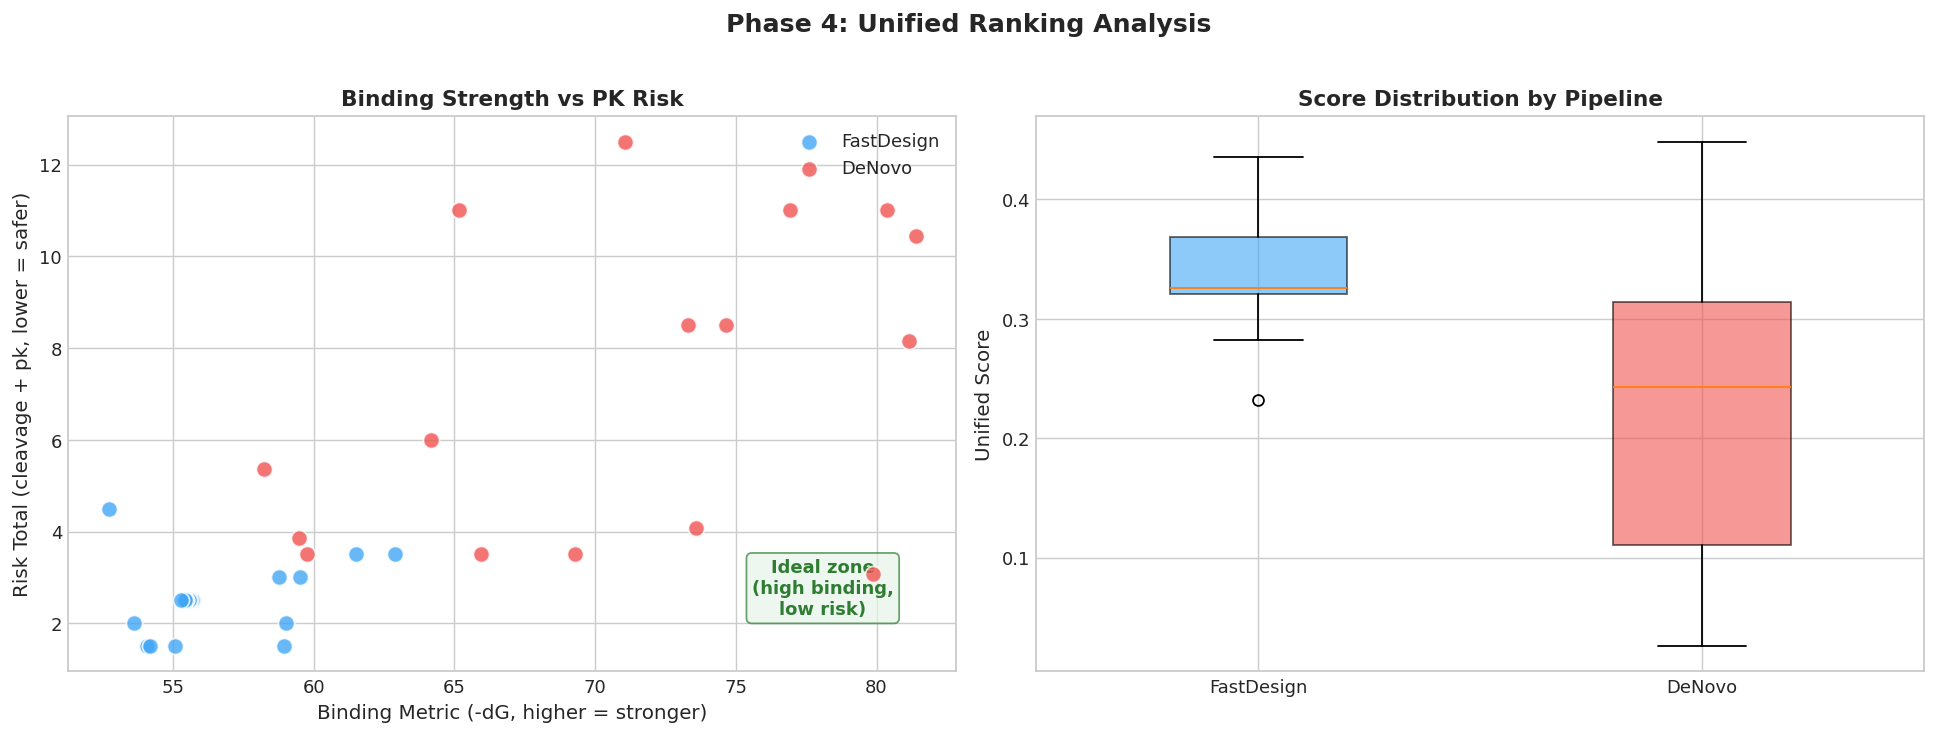

In [20]:
# ===== 4.3 통합 랭킹 시각화: Binding vs Risk Scatter =====
if len(df_unified) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5.5))

    src_colors = {'FastDesign': '#42a5f5', 'DeNovo': '#ef5350'}

    # (1) Binding Metric vs Risk Total (source별 색상)
    for src, color in src_colors.items():
        mask = df_unified['source'] == src
        if mask.any():
            ax1.scatter(df_unified.loc[mask, 'binding_metric'],
                       df_unified.loc[mask, 'risk_total'],
                       c=color, s=80, edgecolor='white', linewidth=1,
                       label=src, alpha=0.8, zorder=5)
    ax1.set_xlabel('Binding Metric (-dG, higher = stronger)', fontsize=11)
    ax1.set_ylabel('Risk Total (cleavage + pk, lower = safer)', fontsize=11)
    ax1.set_title('Binding Strength vs PK Risk', fontweight='bold')
    ax1.legend(fontsize=10)
    # 이상적 영역 표시 (높은 binding, 낮은 risk)
    ax1.annotate('Ideal Zone\n(High Binding,\nLow Risk)',
                xy=(0.85, 0.15), xycoords='axes fraction',
                fontsize=10, color='#2e7d32', fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#e8f5e9', edgecolor='#2e7d32', alpha=0.7))

    # (2) Unified Score 분포 (boxplot by source)
    data_box = []
    labels_box = []
    for src in ['FastDesign', 'DeNovo']:
        mask = df_unified['source'] == src
        if mask.any():
            data_box.append(df_unified.loc[mask, 'unified_score'].values)
            labels_box.append(src)
    bp = ax2.boxplot(data_box, labels=labels_box, patch_artist=True, widths=0.4)
    for patch, src in zip(bp['boxes'], labels_box):
        patch.set_facecolor(src_colors[src])
        patch.set_alpha(0.6)
    ax2.set_ylabel('Unified Score', fontsize=11)
    ax2.set_title('Score Distribution by Pipeline', fontweight='bold')

    plt.suptitle('Phase 4: Unified Ranking Analysis', fontweight='bold', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

### Phase 4 Summary: Unified Ranking Insights

The unified ranking integrates both pipelines under a single scoring framework:

- **Binding Metric (50% weight)**: All candidates scored by dG from Rosetta energy function — FastDesign candidates directly, De Novo candidates via FlexPepDock refinement
- **Structure Metric (30% weight)**: FastDesign uses dSASA (buried surface area at interface), De Novo uses pLDDT (folding confidence)
- **Risk Penalty (20% weight)**: Protease cleavage risk + PK penalty — penalizes candidates with excessive K/R (trypsin sites) or high hydrophobicity

The scatter plots above reveal the **trade-off between binding potency and drug-likeness**. Candidates in the upper-left region of the Binding vs Risk plot represent the best balance of strong binding and low metabolic liability.

---
## Phase 5: 최종 대시보드

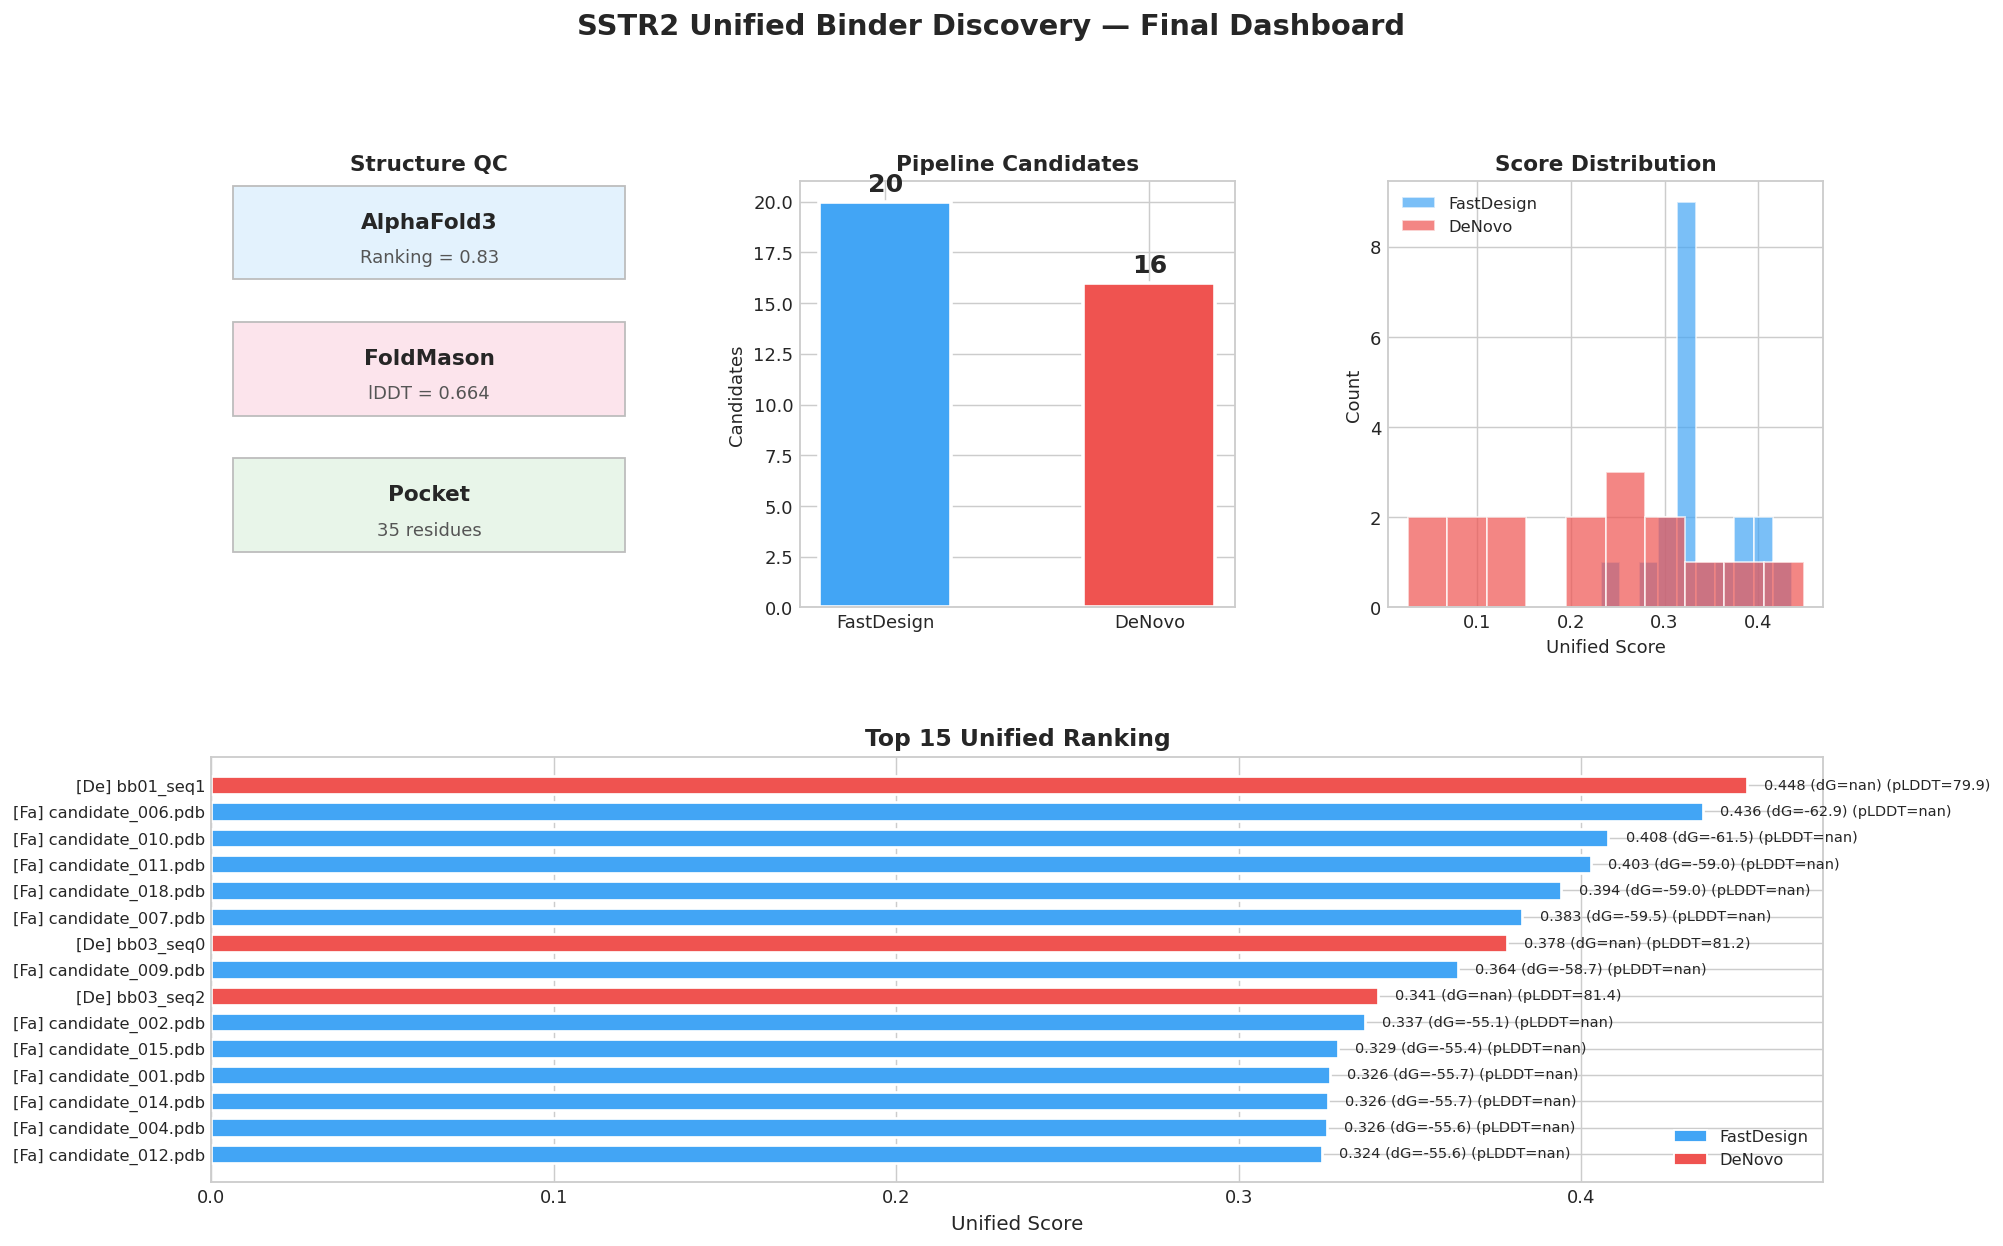

In [21]:
# ===== 5.1 통합 대시보드 시각화 =====
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.35)

# ── (1) 파이프라인 개요 ──
ax = fig.add_subplot(gs[0, 0])
ax.axis('off')
summary_items = [
    ('AlphaFold3', f'Ranking = {scores[best_idx]:.2f}' if confidences else 'N/A', '#e3f2fd'),
    ('FoldMason', 'lDDT = 0.664', '#fce4ec'),
    ('Pocket', f'{pocket["num_pocket_residues"]} residues' if pocket else 'N/A', '#e8f5e9'),
]
for i, (name, val, bg) in enumerate(summary_items):
    y = 0.85 - i * 0.32
    ax.add_patch(plt.Rectangle((0.05, y - 0.08), 0.9, 0.22, facecolor=bg,
                                edgecolor='#bdbdbd', linewidth=1, transform=ax.transAxes, zorder=2))
    ax.text(0.5, y + 0.04, name, transform=ax.transAxes, ha='center', fontsize=12, fontweight='bold', zorder=3)
    ax.text(0.5, y - 0.04, val, transform=ax.transAxes, ha='center', fontsize=10, color='#555', zorder=3)
ax.set_title('Structure QC', fontweight='bold', fontsize=12)

# ── (2) 소스별 후보 수 ──
ax = fig.add_subplot(gs[0, 1])
source_counts = df_unified['source'].value_counts()
src_colors = {'FastDesign': '#42a5f5', 'DeNovo': '#ef5350'}
ax.bar(source_counts.index, source_counts.values,
       color=[src_colors.get(s, '#888') for s in source_counts.index],
       edgecolor='white', linewidth=2, width=0.5)
for i, (s, c) in enumerate(zip(source_counts.index, source_counts.values)):
    ax.text(i, c + 0.5, str(c), ha='center', fontsize=14, fontweight='bold')
ax.set_ylabel('Candidates')
ax.set_title('Pipeline Candidates', fontweight='bold', fontsize=12)

# ── (3) Unified Score 분포 ──
ax = fig.add_subplot(gs[0, 2])
for src, color in src_colors.items():
    mask = df_unified['source'] == src
    if mask.any():
        ax.hist(df_unified.loc[mask, 'unified_score'], bins=10, alpha=0.7,
                color=color, edgecolor='white', label=src)
ax.set_xlabel('Unified Score')
ax.set_ylabel('Count')
ax.set_title('Score Distribution', fontweight='bold', fontsize=12)
ax.legend(fontsize=9)

# ── (4) Top 10 통합 랭킹 ──
ax = fig.add_subplot(gs[1, :])
top_n = min(15, len(df_unified))
top_df = df_unified.head(top_n)
bar_colors = [src_colors.get(s, '#888') for s in top_df['source']]
bars = ax.barh(range(top_n), top_df['unified_score'], color=bar_colors,
               edgecolor='white', linewidth=1.5, height=0.7)
ax.set_yticks(range(top_n))
ylabels = [f"[{row['source'][:2]}] {row['name']}" for _, row in top_df.iterrows()]
ax.set_yticklabels(ylabels, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Unified Score', fontsize=11)
ax.set_title('Top 15 Unified Ranking', fontweight='bold', fontsize=13)

# 점수 라벨
for i, (_, row) in enumerate(top_df.iterrows()):
    label = f"{row['unified_score']:.3f}"
    if row.get('dG_REU') is not None:
        label += f" (dG={row['dG_REU']:.1f})"
    if row.get('plddt') is not None:
        label += f" (pLDDT={row['plddt']:.1f})"
    ax.text(row['unified_score'] + 0.005, i, label, va='center', fontsize=8)

# 범례
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, edgecolor='white', label=s) for s, c in src_colors.items()]
ax.legend(handles=legend_elements, fontsize=9, loc='lower right')

fig.suptitle('SSTR2 Unified Binder Discovery — Final Dashboard',
             fontweight='bold', fontsize=16, y=1.01)
plt.show()

In [22]:
# ===== 5.2 Top 5 후보 상세 카드 =====
top5 = df_unified.head(5)

html_cards = ''
for i, (_, row) in enumerate(top5.iterrows()):
    src_badge_color = '#1565c0' if row['source'] == 'FastDesign' else '#e53935'
    metrics = []
    if row.get('dG_REU') is not None:
        metrics.append(f'dG = {row["dG_REU"]:.1f} REU')
    if row.get('plddt') is not None:
        metrics.append(f'pLDDT = {row["plddt"]:.1f}')
    if row.get('dSASA') is not None and row['dSASA']:
        metrics.append(f'dSASA = {row["dSASA"]:.0f} A^2')
    metrics.append(f'Risk = {row["risk_total"]:.1f}')

    html_cards += f'''
    <div style="background:#fff;border:2px solid {src_badge_color};border-radius:12px;
                padding:16px;margin:8px 0;box-shadow:0 2px 4px rgba(0,0,0,0.1)">
      <div style="display:flex;justify-content:space-between;align-items:center">
        <div>
          <span style="background:{src_badge_color};color:white;padding:3px 10px;
                       border-radius:20px;font-size:12px;font-weight:bold">
            #{i+1} {row['source']}
          </span>
          <span style="margin-left:10px;font-weight:bold;font-size:14px">{row['name']}</span>
        </div>
        <span style="font-size:20px;font-weight:bold;color:{src_badge_color}">
          {row['unified_score']:.3f}
        </span>
      </div>
      <div style="font-family:monospace;font-size:13px;margin:8px 0;padding:6px;
                  background:#f5f5f5;border-radius:6px">
        {row['sequence']}
      </div>
      <div style="font-size:12px;color:#666">
        Length: {row['length']}aa &nbsp;|&nbsp; {' &nbsp;|&nbsp; '.join(metrics)}
      </div>
    </div>'''

display(HTML(f'''
<div style="max-width:800px">
  <h3>Top 5 Unified Candidates</h3>
  {html_cards}
</div>
'''))

### Top Candidates Analysis

The Top 5 unified candidates represent the best-scoring peptides from both design approaches. Key factors to evaluate for each candidate:

1. **Binding Energy (dG)**: More negative = stronger binding to SSTR2. Compare against wild-type SST14 dG as baseline
2. **Sequence Conservation**: How many pharmacophore residues (F7, W8, K9, T10) are preserved? Mutations at these positions may indicate novel binding modes
3. **Risk Profile**: Low cleavage_risk + low pk_penalty = better in vivo stability and pharmacokinetics
4. **Source Pipeline**: FastDesign candidates are SST14 derivatives (familiar chemistry), De Novo candidates may have entirely novel scaffolds (higher innovation but higher risk)

The 3D visualizations below allow structural comparison of how each candidate interacts with the SSTR2 binding pocket.

> **입력**: `df_unified` (통합 랭킹 DataFrame), `candidates/*.pdb` (FastDesign PDB), `refined/*.pdb` (Refined PDB)
> **출력**: Top 3 통합 후보의 3D 비교 뷰, HTML 파일
> **왜 실행하는가**: 최종 통합 랭킹 Top 3 후보를 나란히 3D로 비교한다. FastDesign과 De Novo 후보가 SSTR2 포켓에 어떻게 다르게 결합하는지 시각적으로 확인할 수 있다.

In [ ]:
# ── 5.3 통합 Top 3 후보 3D 비교 ──
if HAS_3D and len(df_unified) >= 3:
    top3_unified = df_unified.head(3)
    unified_pdbs = []
    unified_labels = []

    for _, row in top3_unified.iterrows():
        pdb_found = None
        if row['source'] == 'FastDesign':
            # FastDesign: candidates/ 또는 refined/ 디렉토리
            cand_name = row.get('name', '')
            for search_dir in [Path('refined'), Path('candidates')]:
                # refined 우선 탐색
                if search_dir == Path('refined'):
                    refined_name = cand_name.replace('candidate_', 'refined_')
                    p = search_dir / refined_name
                else:
                    p = search_dir / cand_name
                if p.exists():
                    pdb_found = str(p)
                    break
        elif row['source'] == 'DeNovo':
            # De Novo: denovo_refined/ 또는 esmfold PDB
            name = row.get('name', '')
            # refined 결과 탐색
            for i in range(20):
                p = OUTPUT_DIR / 'denovo_refined' / f'denovo_refined_{i+1:03d}.pdb'
                if p.exists():
                    pdb_found = str(p)
                    break

        if pdb_found:
            src = row['source'][:2]
            score = row['unified_score']
            unified_pdbs.append(pdb_found)
            unified_labels.append(f"[{src}] {row['name']} ({score:.3f})")

    if unified_pdbs:
        display(HTML(
            '<div style="background:#f3e5f5;padding:12px;border-radius:8px;margin-bottom:8px">'
            f'<b>Unified Ranking Top {len(unified_pdbs)} Candidates 3D Comparison</b><br>'
            '<span style="color:#6495ED">&#9632;</span> SSTR2 Receptor &nbsp;|&nbsp; '
            'Each color = each candidate peptide'
            '</div>'
        ))
        show_comparison_3d(unified_pdbs, unified_labels)
    else:
        print('Unified Top 3 PDB files not found — skipping 3D comparison')
elif not HAS_3D:
    print('py3Dmol not installed — skipping 3D visualization')

---
## Phase 6: 방사성의약품(Radiopharmaceutical) 적합성 평가

### SSTR2와 PRRT

SSTR2는 **PRRT (Peptide Receptor Radionuclide Therapy)** 의 핵심 타겟이다.
현재 임상에서 사용되는 대표적 방사성의약품:

| 방사성의약품 | 구성 | 용도 |
|------------|------|------|
| **[177Lu]Lu-DOTATATE** (Lutathera) | DOTA-킬레이터 + Octreotide 유도체 + 177Lu | NET 치료 (FDA 승인) |
| **[68Ga]Ga-DOTATATE** | DOTA + Octreotide 유도체 + 68Ga | PET 진단 (NET 병소 영상) |
| **[90Y]Y-DOTATOC** | DOTA + Octreotide 유도체 + 90Y | 대형 종양 치료 |

### 방사성의약품 설계 4대 요구조건

본 파이프라인의 후보 펩타이드가 방사성의약품으로 발전하려면:

| 요구 조건 | 본 파이프라인의 기여 |
|-----------|-------------------|
| **1. 높은 수용체 결합력** (낮은 dG) | FastDesign + FlexPepDock으로 dG 직접 최적화 |
| **2. 환형 구조 유지** (이황화결합) | Cys3-Cys14 보존 강제 (FastDesign), 환형 모티프 보존 |
| **3. 킬레이터 접합점** (N/C 말단 or 비핵심 Lys) | 약효단 분석으로 비결합 잔기 식별 → 접합 위치 제안 가능 |
| **4. 서브타입 선택성** (SSTR2-only vs pan-SSTR) | 향후 FoldMason으로 SSTR1~5 구조 비교 필요 |

### Theranostics 확장 가능성

| 전략 | 진단 | 치료 | 필요 데이터 |
|------|------|------|------------|
| SSTR2 선택적 | 68Ga-PET | 177Lu-PRRT | SSTR 서브타입 선택성 분석 |
| 범-SSTR | 68Ga-PET (더 넓은 검출) | 177Lu-PRRT | FoldMason 보존 잔기 |
| 소분자 기반 | 18F-PET 가능 | TBD | Arm 1 (MolMIM) 결과 |

> **현재 상태**: 본 파이프라인은 요구 조건 1(결합력), 2(환형 구조), 3(접합점 후보)을 부분적으로 충족한다.
> 요구 조건 4(서브타입 선택성)와 D-아미노산 도입은 후속 연구로 남아있다.

In [23]:
# ===== 5.4 Next Steps =====
display(HTML('''
<div style="background:linear-gradient(135deg,#1565c0,#42a5f5);color:white;
            padding:30px;border-radius:12px;margin:20px 0">
  <h2 style="margin-top:0">Next Steps</h2>

  <h3 style="margin-top:12px">A. Pipeline Extension</h3>
  <ol style="font-size:15px;line-height:2.0">
    <li><b>AlphaFold3 Re-prediction</b>: Re-predict SSTR2 complex structures with Top 5 candidate sequences</li>
    <li><b>MD Simulation</b>: Validate binding stability via molecular dynamics (AMBER/GROMACS, 100ns+)</li>
    <li><b>Arm 1/2 Integration</b>: Add MolMIM+DiffDock small molecule candidates and Ala-scan variants to unified ranking</li>
    <li><b>Experimental Validation</b>: In vitro binding assays (SPR, ITC) for IC50/Kd measurement</li>
  </ol>

  <h3 style="margin-top:12px">B. Radiopharmaceutical Workflow</h3>
  <ol style="font-size:15px;line-height:2.0" start="5">
    <li><b>DOTA/NOTA Chelator Conjugation Site</b>: Identify non-binding residues via Rosetta energy decomposition for chelator attachment at N/C-terminus or non-essential Lys side chains</li>
    <li><b>D-amino Acid Introduction</b>: Enhance protease resistance via D-Phe/D-Trp substitution using PeptideCyclizeMover</li>
    <li><b>SSTR Subtype Selectivity</b>: Compare SSTR1-5 structures via FoldMason to identify SSTR2-selective residues</li>
  </ol>

  <h3 style="margin-top:12px">C. Clinical Translation</h3>
  <ol style="font-size:15px;line-height:2.0" start="8">
    <li><b>Cyclic Peptide Synthesis</b>: Chemical synthesis of top candidates as disulfide-bonded cyclic peptides</li>
    <li><b>Radiolabeling Test</b>: 177Lu/68Ga labeling + cell binding assays (SSTR2+ vs SSTR2- cell lines)</li>
  </ol>
</div>
'''))

print(f'\n=== Execution complete ===')
print(f'Unified candidates: {len(df_unified)}')
print(f'Results saved: {OUTPUT_DIR / "unified_ranking.csv"}')
print(f'Top 1: [{df_unified.iloc[0]["source"]}] {df_unified.iloc[0]["name"]} '
      f'(score={df_unified.iloc[0]["unified_score"]:.3f})')


=== 실행 완료 ===
통합 후보: 36개
결과 저장: unified_results/unified_ranking.csv
Top 1: [DeNovo] bb01_seq1 (score=0.448)
